# **1. Importing the libraries & packages**

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from scipy.stats import uniform, randint
import pickle
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/content/Train.csv')

# **2. Exploratory Data Analysis**

In [6]:
df.apply(lambda x : len(x.unique()))

,0
Item_Identifier,1559
Item_Weight,416
Item_Fat_Content,5
Item_Visibility,7880
Item_Type,16
Item_MRP,5938
Outlet_Identifier,10
Outlet_Establishment_Year,9
Outlet_Size,4
Outlet_Location_Type,3


In [7]:
df.duplicated().sum()

0

In [8]:
df.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# **3. Data Cleaning**

In [10]:
cat_col = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'object':
        cat_col.append(x)
display(cat_col)

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [11]:
cat_col.remove('Item_Identifier')
cat_col.remove('Outlet_Identifier')

In [12]:
display(cat_col)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [13]:
for col in cat_col:
    print(col,len(df[col].unique()))

Item_Fat_Content 5
Item_Type 16
Outlet_Size 4
Outlet_Location_Type 3
Outlet_Type 4


In [14]:
for col in cat_col:
    print(col)
    print(df[col].value_counts(),'\n')
    print('-'*55)

Item_Fat_Content
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64 

-------------------------------------------------------
Item_Type
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64 

-------------------------------------------------------
Outlet_Size
Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64 

-------------------------------------------------------
Outlet_Location_Type
Outlet_Location_Type
Tier 3    3350
Tier 2  

In [15]:
miss_bool = df['Item_Weight'].isnull()
Item_Weight_Null = df[df['Item_Weight'].isnull()]
display(Item_Weight_Null)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


In [16]:
Item_Weight_Null['Item_Identifier'].value_counts()

,count
Item_Identifier,
FDK08,2
FDA08,2
FDV23,2
FDY56,2
FDI04,2
...,...
FDM44,1
FDZ48,1
FDK41,1


In [17]:
Item_Weight_Mean = df.pivot_table(values = 'Item_Weight', index = 'Item_Identifier')
display(Item_Weight_Mean)

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


In [18]:
for i, item in enumerate(df['Item_Identifier']):
    if miss_bool[i]:
        if item in Item_Weight_Mean:
            df['Item_Weight'][i] = Item_Weight_Mean.loc[item]['Item_Weight']
        else:
            df['Item_Weight'][i] = np.mean(df['Item_Weight'])

In [19]:
df['Item_Weight'].isna().sum()

0

In [20]:
df['Outlet_Size'].value_counts()

,count
Outlet_Size,
Medium,2793
Small,2388
High,932


In [21]:
df['Outlet_Size'].isnull().sum()

2410

In [22]:
Outlet_Size_Null = df[df['Outlet_Size'].isna()]
display(Outlet_Size_Null)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
...,...,...,...,...,...,...,...,...,...,...,...,...
8502,NCH43,8.420,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688
8508,FDW31,11.350,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.100,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.000,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


In [23]:
Outlet_Size_Null['Outlet_Type'].value_counts()

,count
Outlet_Type,
Supermarket Type1,1855
Grocery Store,555


In [24]:
df.groupby(['Outlet_Type','Outlet_Size']).agg({'Outlet_Type':[np.size]})

Outlet_Type
                                     size
Outlet_Type       Outlet_Size            
Grocery Store     Small               528
Supermarket Type1 High                932
                  Medium              930
                  Small              1860
Supermarket Type2 Medium              928
Supermarket Type3 Medium              935

In [25]:
Outlet_Size_Mode = df.pivot_table(values = 'Outlet_Size', columns = 'Outlet_Type', aggfunc = (lambda x : x.mode()[0]))
display(Outlet_Size_Mode)

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [26]:
miss_bool = df['Outlet_Size'].isna()
df.loc[miss_bool,'Outlet_Size'] = df.loc[miss_bool,'Outlet_Type'].apply(lambda x : Outlet_Size_Mode[x])

In [27]:
df['Outlet_Size'].isna().sum()

0

In [28]:
df.isna().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


In [29]:
sum(df['Item_Visibility'] == 0)

526

In [30]:
df.loc[:,'Item_Visibility'].replace([0],[df['Item_Visibility'].mean()],inplace = True)

In [31]:
sum(df['Item_Visibility'] == 0)

0

In [32]:
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5089
Regular,2889
LF,316
reg,117
low fat,112


### **After seeing the unique value counts from the `Item_Fat_Content` column, there have been some mistyping occured like the same categories were typed under different names. For further processing, all the mistypings are corrected and named under a single category. Checking out for the value counts of `Item_Fat_Content` column**

In [33]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF' : 'Low Fat', 'low fat' : 'Low Fat', 'reg' : 'Regular'})
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


In [34]:
df['New_Item_Type'] = df['Item_Identifier'].apply(lambda x : x[:2])
df['New_Item_Type'].value_counts()

,count
New_Item_Type,
FD,6125
NC,1599
DR,799


In [35]:
df['New_Item_Type'] = df['New_Item_Type'].replace({'FD' : 'Food', 'NC' : 'Non-Consumables', 'DR' : 'Drinks'})
df['New_Item_Type'].value_counts()

,count
New_Item_Type,
Food,6125
Non-Consumables,1599
Drinks,799


In [36]:
df.groupby(['New_Item_Type','Item_Fat_Content']).agg({'Outlet_Type':[np.size]})

Outlet_Type
                                        size
New_Item_Type   Item_Fat_Content            
Drinks          Low Fat                  728
                Regular                   71
Food            Low Fat                 3190
                Regular                 2935
Non-Consumables Low Fat                 1599

In [37]:
df.loc[df['New_Item_Type'] == 'Non-Consumables','Item_Fat_Content'] = 'Non-Edible'
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,3918
Regular,3006
Non-Edible,1599


In [38]:
df['Outlet_Establishment_Year'].unique()

array([1999, 2009, 1998, 1987, 1985, 2002, 2007, 1997, 2004])

In [39]:
curr_time = datetime.datetime.now()
df['Outlet_Years'] = df['Outlet_Establishment_Year'].apply(lambda x: curr_time.year - x)

# **4. Data Visualization**

### **Plotting the Bar Graph with count of 'Item_Fat_Content'**

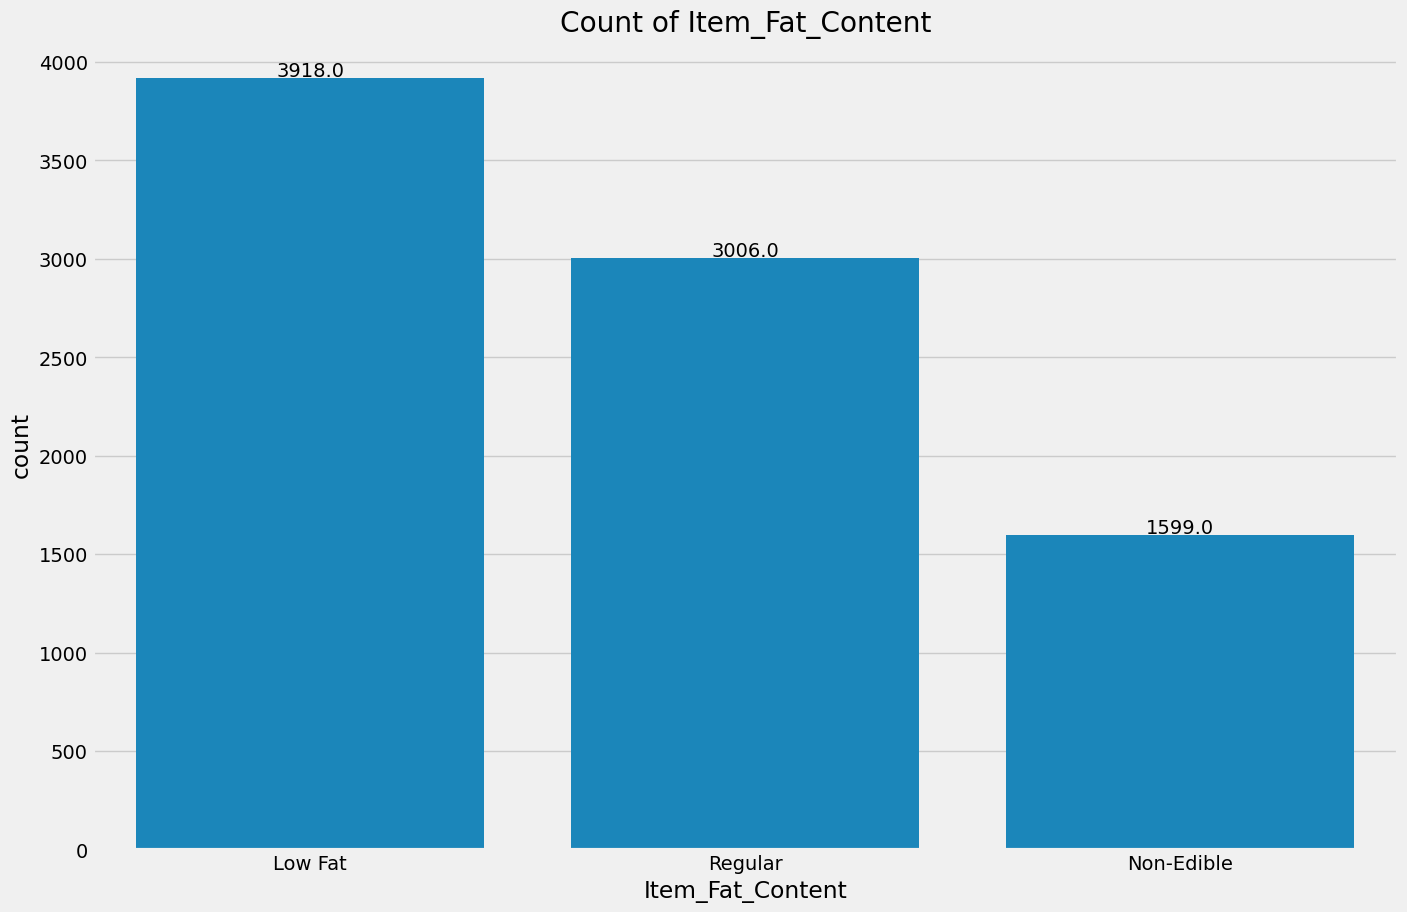

In [40]:
plt.rcParams['figure.figsize'] = 15,10
plt.style.use('fivethirtyeight')
plot = sns.countplot(x = df['Item_Fat_Content'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Item_Fat_Content')
plt.show()

### **Plotting the Bar Graph with count of 'Item_Type'**

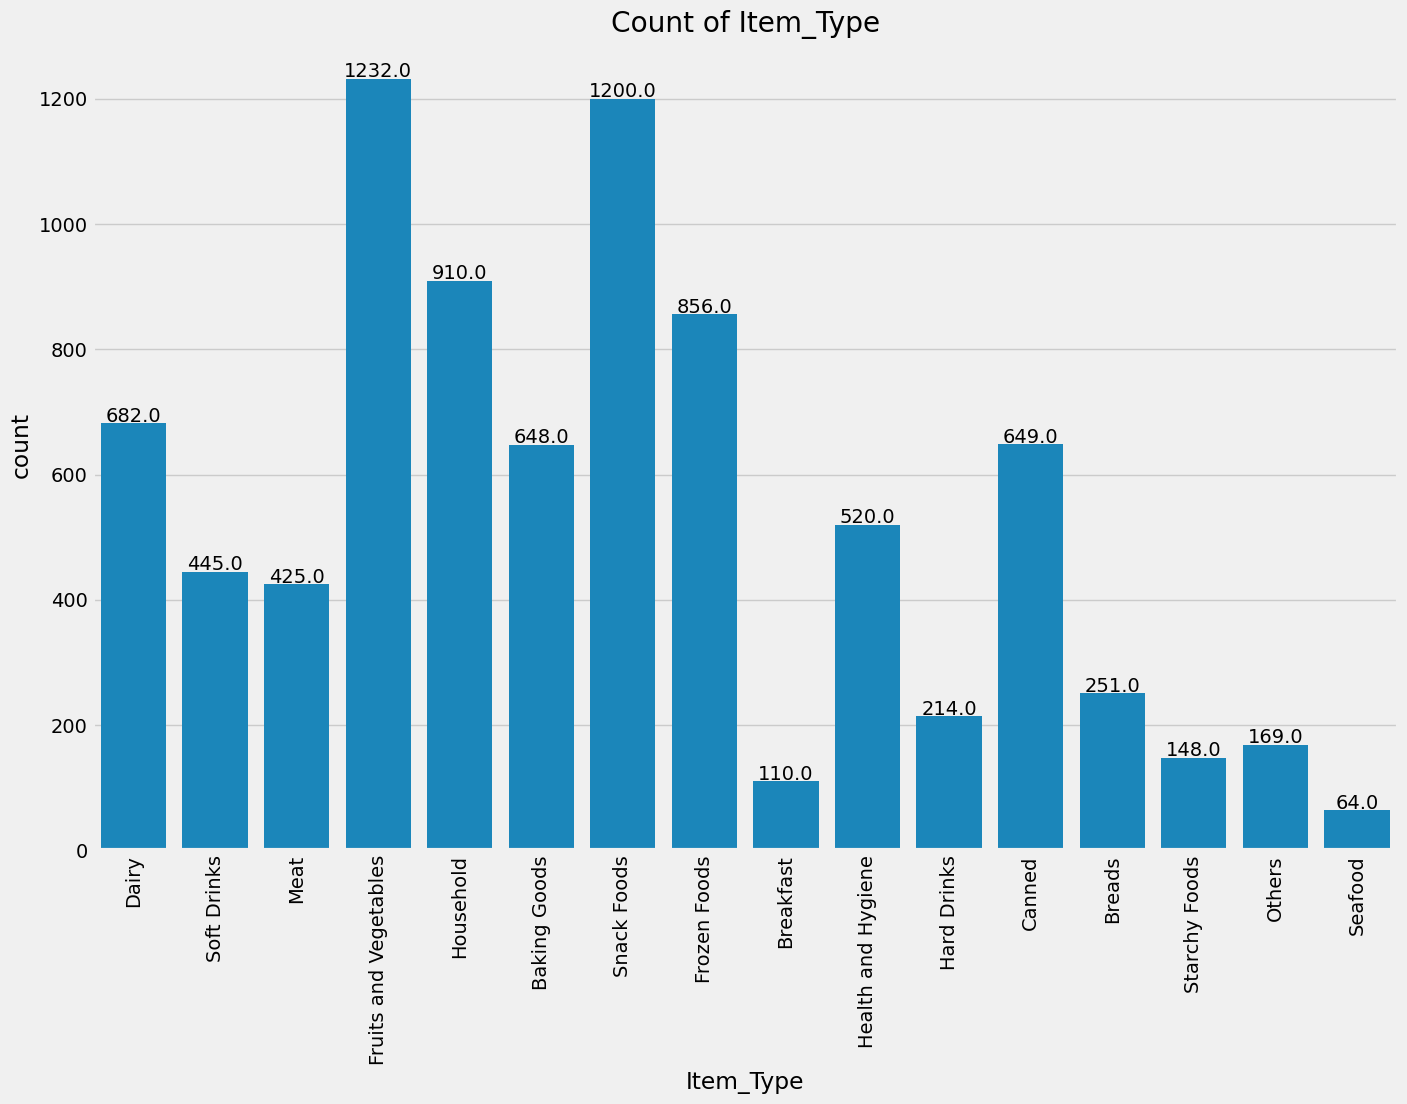

In [41]:
plot = sns.countplot(x = df['Item_Type'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.xticks(rotation = 90)
plt.title('Count of Item_Type')
plt.show()

### **Plotting the Bar Graph with count of 'Outlet_Establishment_Year'**

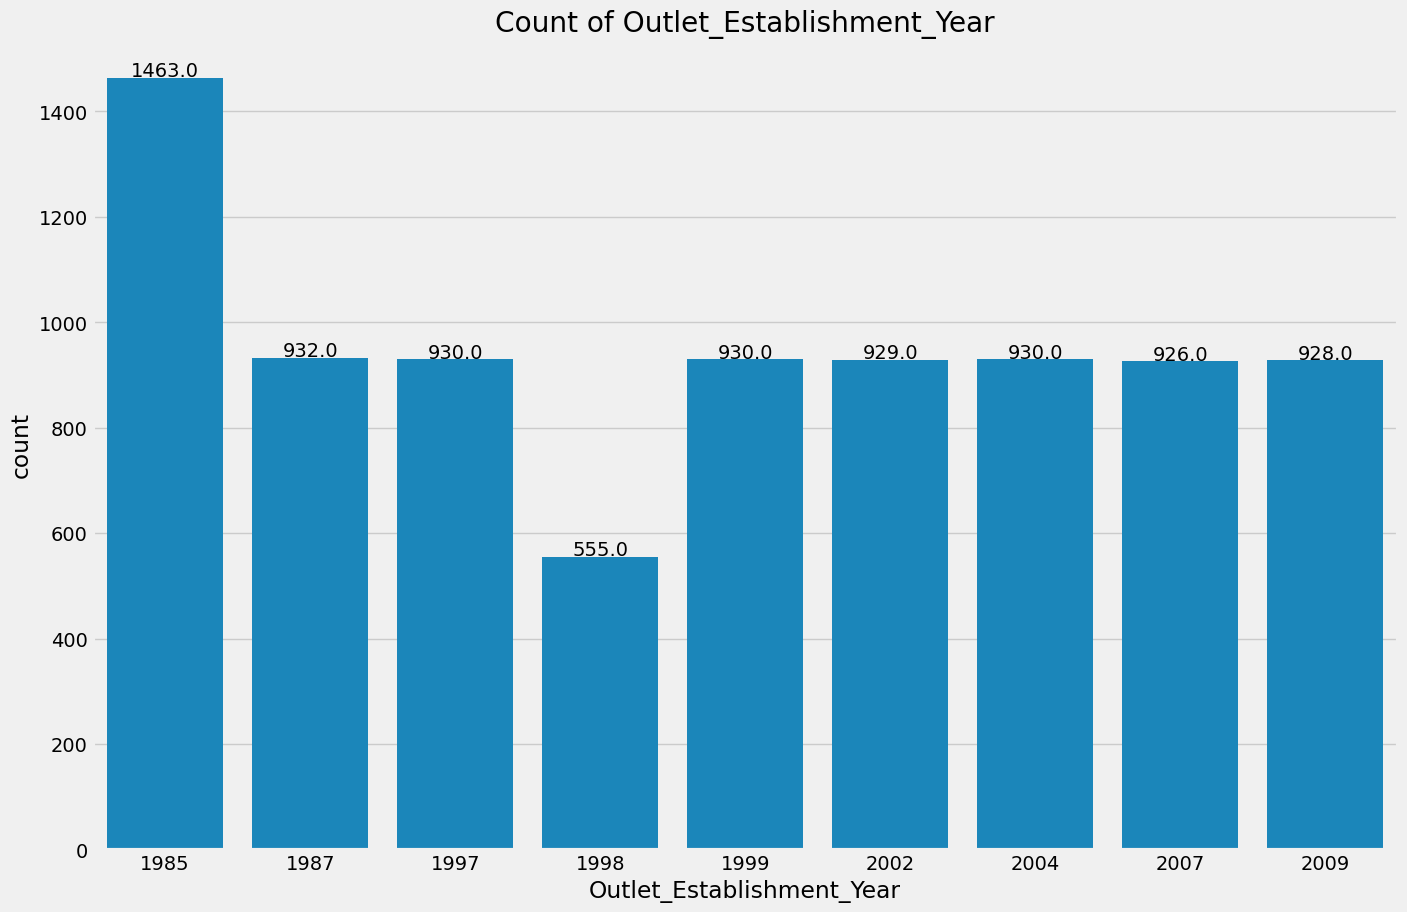

In [44]:
plot = sns.countplot(x = df['Outlet_Establishment_Year'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Establishment_Year')
plt.show()

### **Plotting the Bar Graph with count of 'Outlet_Location_Type'**

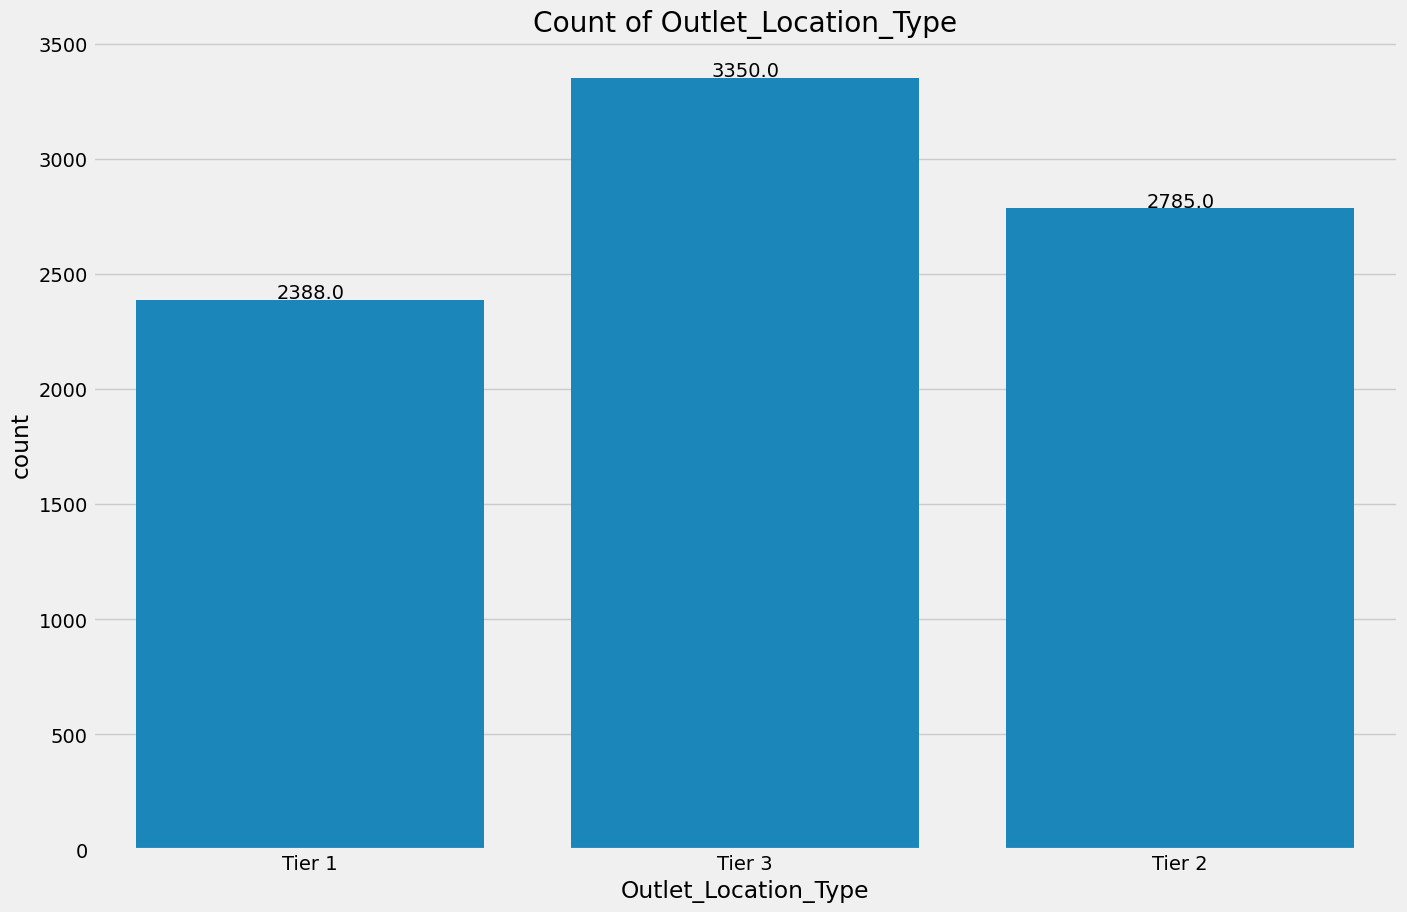

In [45]:
plot = sns.countplot(x = df['Outlet_Location_Type'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Location_Type')
plt.show()

### **Plotting the Bar Graph with count of 'Outlet_Size'**

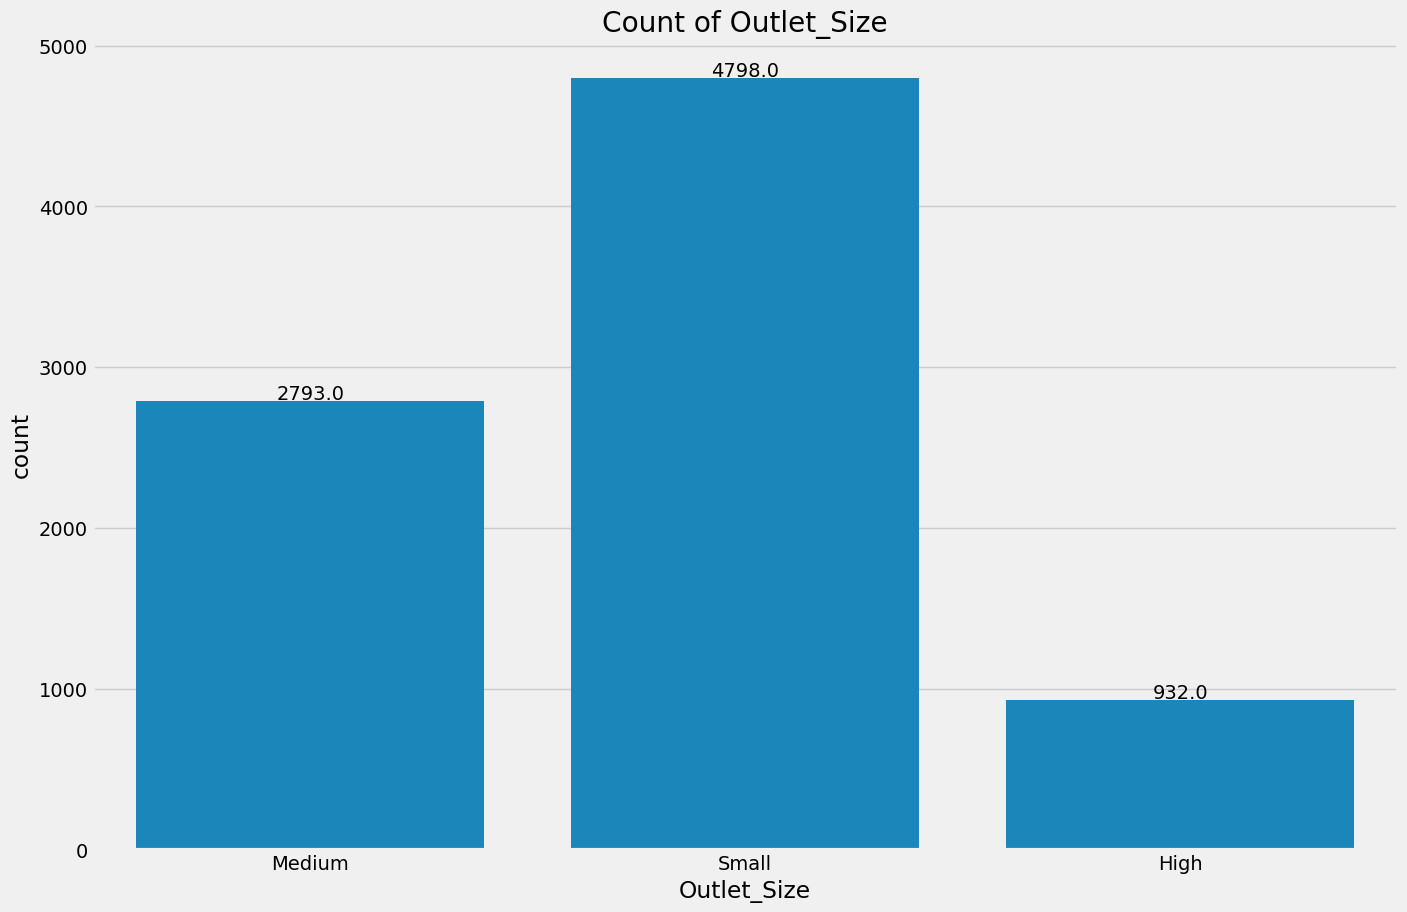

In [46]:
plot = sns.countplot(x = df['Outlet_Size'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Size')
plt.show()

### **Plotting the Bar Graph with count of 'Outlet_Type'**

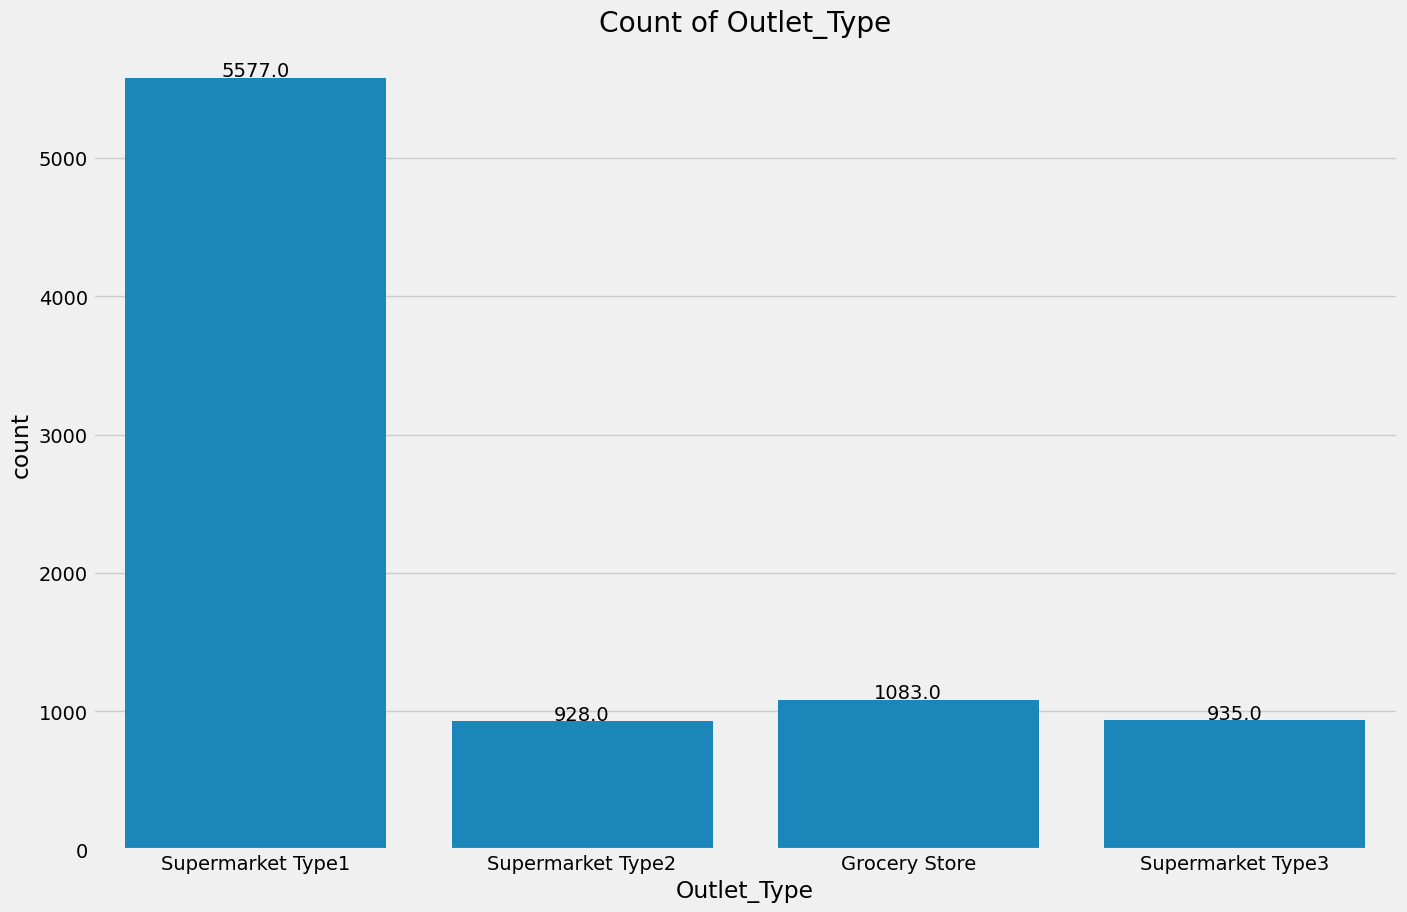

In [47]:
plot = sns.countplot(x = df['Outlet_Type'])
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Outlet_Type')
plt.show()

### **Visualizing the data distribution of the 'Item_weight' column against the density distribution using Seaborn Distplot**

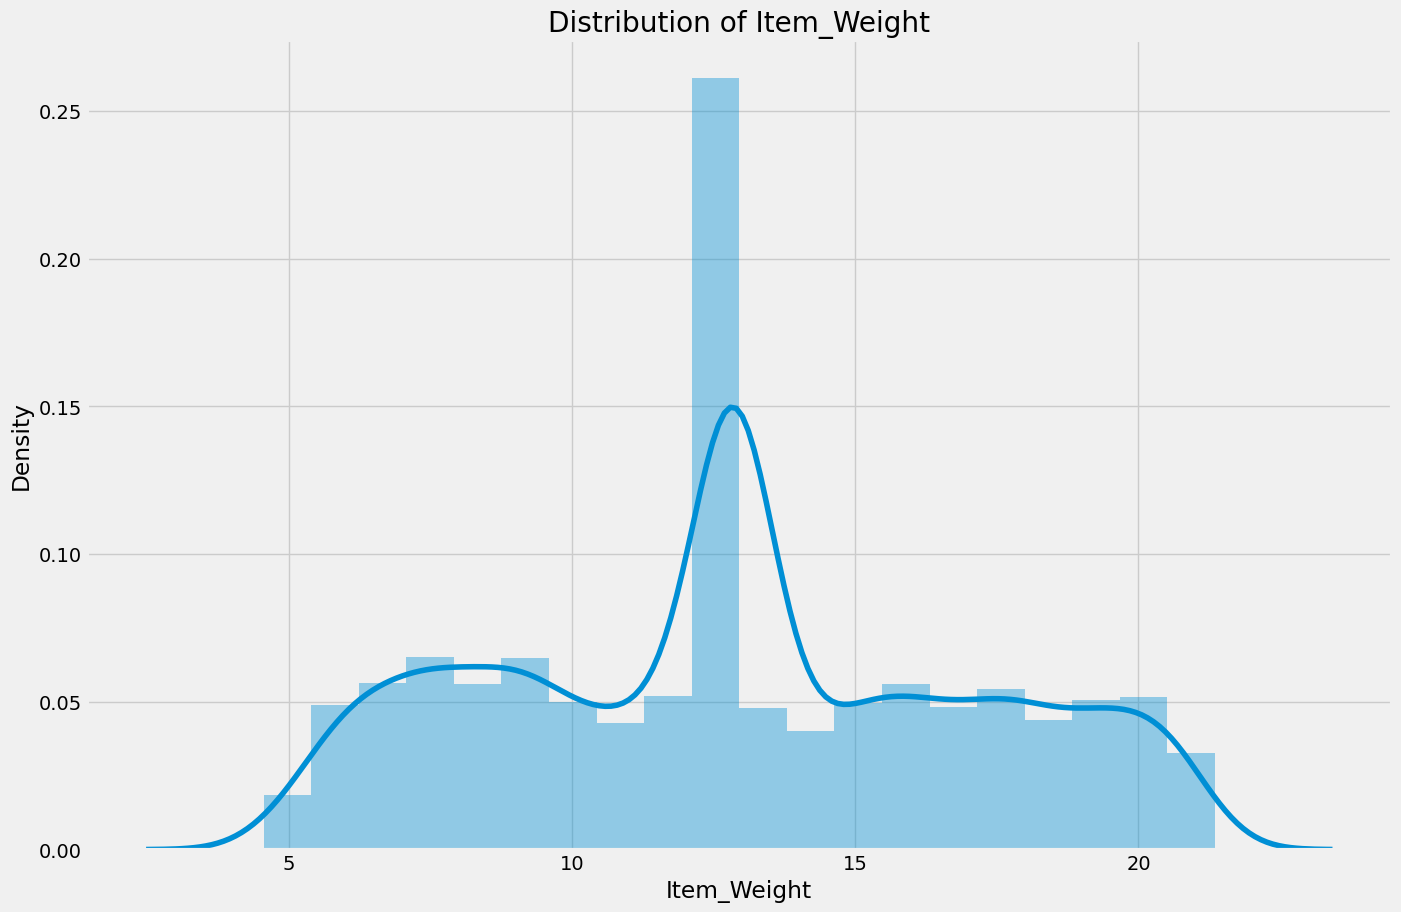

In [48]:
sns.distplot(df['Item_Weight'],bins = 20)
plt.title('Distribution of Item_Weight')
plt.show()

### **Correlation Heat Map**

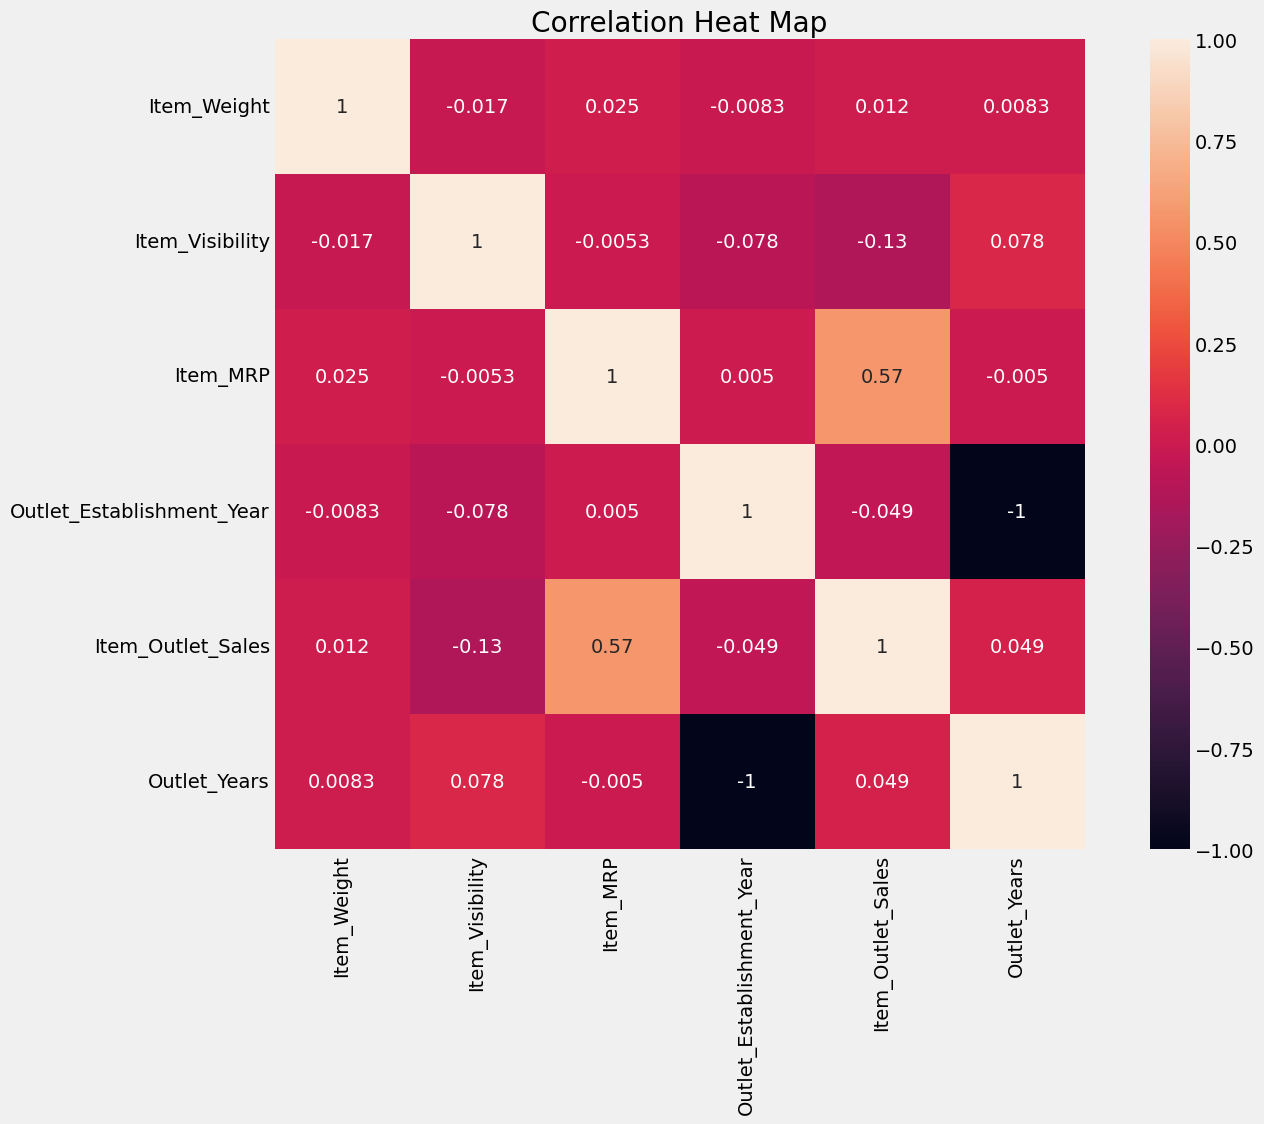

In [51]:
numerical_features = df.select_dtypes(include=np.number).columns
numerical_df = df[numerical_features]

sns.heatmap(numerical_df.corr(), cbar=True, annot=True, square=True)
plt.title('Correlation Heat Map')
plt.show()

# **5. Data Preprocessing**

### **Label Encoding the `Outlet_Identifier` column and adding it as a new column `Outlet` to the dataset**

In [55]:
le = LabelEncoder()
df['Outlet'] = le.fit_transform(df['Outlet_Identifier'])

In [56]:
df.dtypes

,0
Item_Identifier,object
Item_Weight,float64
Item_Fat_Content,int64
Item_Visibility,float64
Item_Type,int64
Item_MRP,float64
Outlet_Identifier,object
Outlet_Establishment_Year,int64
Outlet_Size,int64
Outlet_Location_Type,int64


In [57]:
cat_col = ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type','New_Item_Type']
for col in cat_col:
    df[col] = le.fit_transform(df[col])

### **One Hot Encoding the columns `Item_Fat_Content`,`Outlet_Size`,`Outlet_Location_Type`,`Outlet_Type`,`New_Item_Type` using  <span style = 'background : green'><span style = 'color : white'> get dummies </span> </span> function**

In [58]:
df = pd.get_dummies(df,columns = ['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type','New_Item_Type'])

In [59]:
x = df.drop(['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year','Item_Outlet_Sales'],axis=1)
y=df['Item_Outlet_Sales']

# **5. Model Fitting**

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)

In [63]:
def train(model, x, y):
    model.fit(x, y)
    pred = model.predict(x)
    cv_score = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=10)
    print('Model Report : \n')
    print('Scoring - neg_mean_squared_error')
    print(cv_score, '\n')
    cv_score = np.abs(np.mean(cv_score))
    print('Absolute Average of neg_mean_squared_error : ', cv_score)
    cv_score = cross_val_score(model, x, y, cv=10)
    print()
    print('R2 Score')
    print(cv_score, '\n')
    cv_score = np.mean(cv_score)
    print('Average R2 Score : ', cv_score, '\n')
    print('Accuracy for Full Data :')
    print('R2 Score : ', r2_score(y, pred), '\n')
    coef = pd.Series(model.coef_, x.columns).sort_values()
    print(coef)
    coef.plot(kind='bar', title="Model Coefficients")
    plt.show()

### **Fitting the Linear Regression model**

Model Report : 

Scoring - neg_mean_squared_error
[-1308363.54107399 -1317107.74968154 -1282613.70557151 -1368186.27437432
 -1195693.21293122 -1314995.99930038 -1224984.24333567 -1371452.26391224
 -1138875.63213369 -1309200.11182761] 

Absolute Average of neg_mean_squared_error :  1283147.2734142183

R2 Score
[0.54291572 0.54630942 0.5775896  0.57662039 0.62639187 0.51661562
 0.57357095 0.50602569 0.57904273 0.52933781] 

Average R2 Score :  0.5574419800320544 

Accuracy for Full Data :
R2 Score :  0.5625380588222987 

Outlet_Type_1            -2048.464861
Outlet_Size_1            -1943.435840
Outlet_Size_2            -1471.250364
Outlet_Type_2            -1386.649119
Outlet_Type_0            -1039.861519
Outlet_Location_Type_2    -965.994677
Item_Visibility           -192.479994
Outlet_Years              -188.339775
New_Item_Type_0            -22.219086
Item_Fat_Content_1         -18.410188
New_Item_Type_2            -18.410188
Item_Type                    0.020929
Item_Weight        

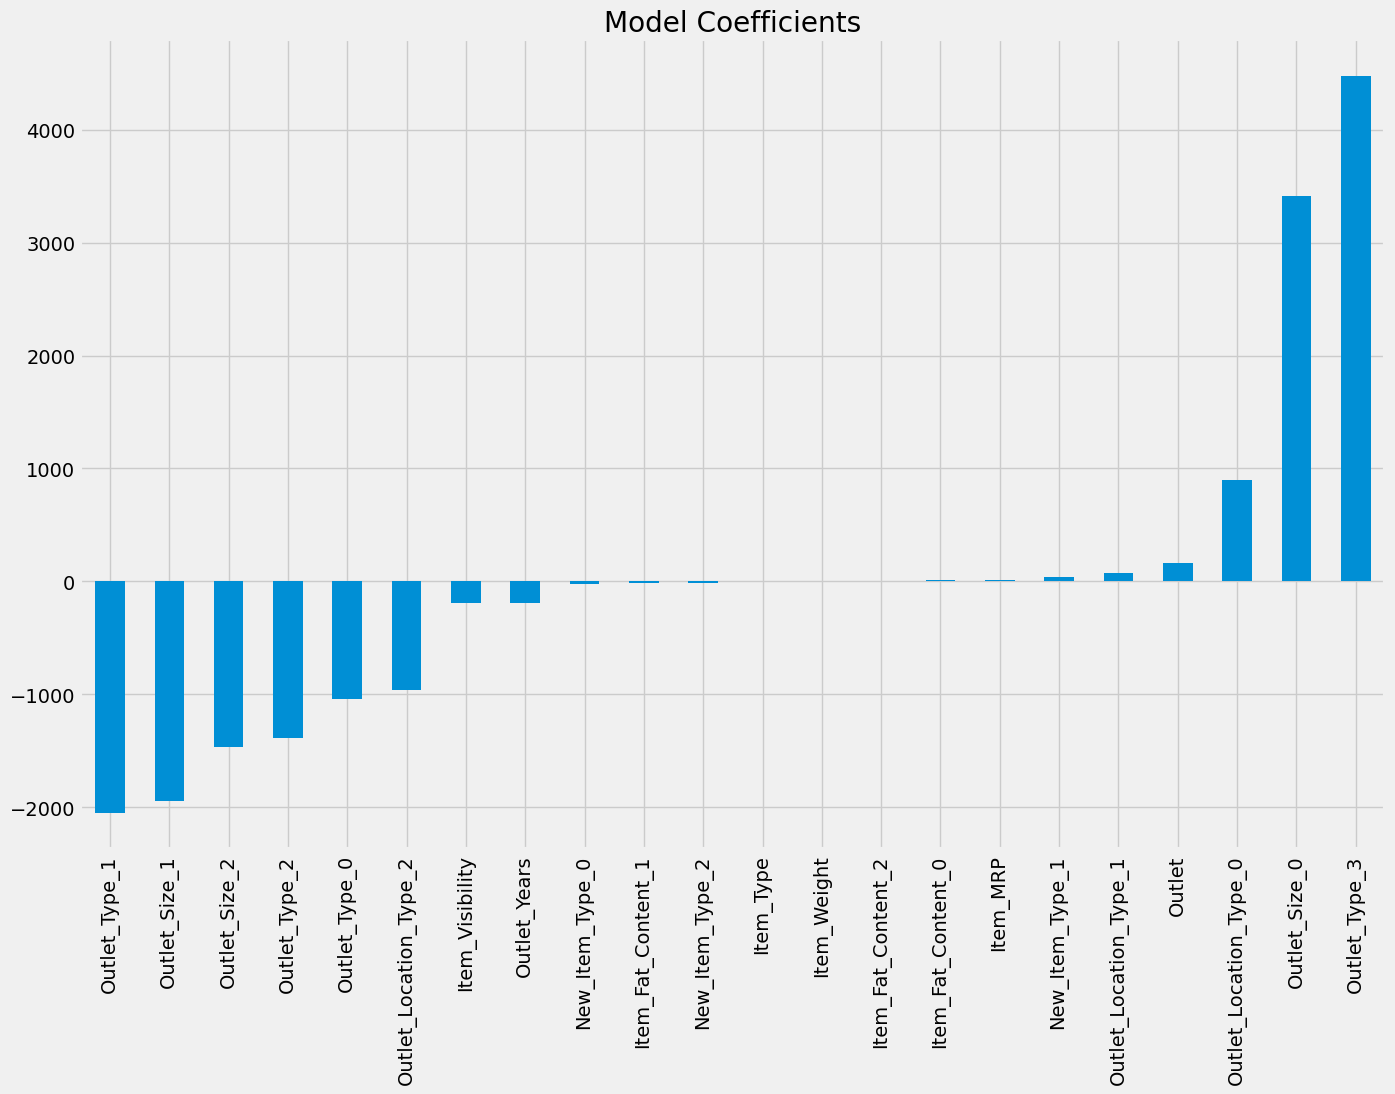

In [65]:
model = LinearRegression()
train(model,x_train,y_train)



### **Fitting the Ridge model**

Model Report : 

Scoring - neg_mean_squared_error
[-1311676.60439693 -1317548.24478519 -1278486.73397309 -1366799.80230182
 -1195328.84386422 -1313940.76194966 -1225439.73061375 -1377121.28122857
 -1140959.60412328 -1315700.47222438] 

Absolute Average of neg_mean_squared_error :  1284300.2079460893

R2 Score
[0.54175828 0.54615769 0.57894876 0.57704943 0.62650572 0.51700352
 0.57341239 0.5039838  0.57827244 0.52700091] 

Average R2 Score :  0.5570092939455755 

Accuracy for Full Data :
R2 Score :  0.5620606058825063 

Outlet_Type_0            -1594.702494
Outlet_Size_1             -383.821865
Outlet_Type_2             -355.278936
Outlet_Size_2             -347.709077
Outlet_Type_1             -289.154290
Outlet_Location_Type_2    -269.491360
Item_Visibility           -185.714225
Outlet_Years               -41.025717
New_Item_Type_0            -22.147831
Item_Fat_Content_1         -18.949832
New_Item_Type_2            -18.949832
Item_Type                    0.172296
Item_Weight        

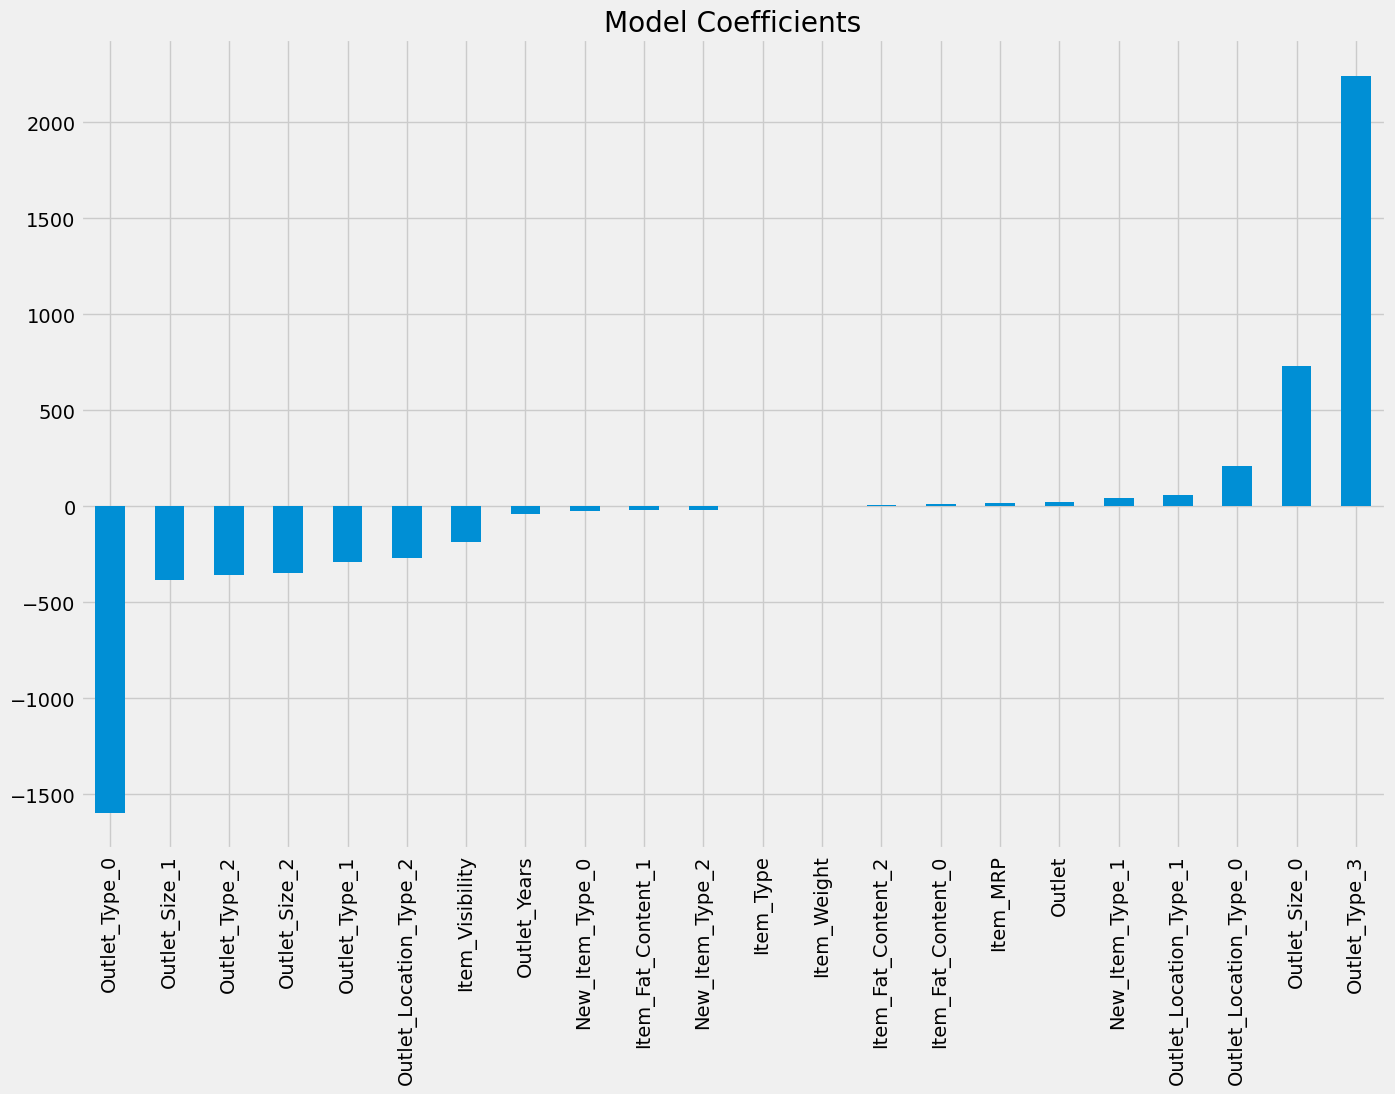

In [66]:
model = Ridge()
train(model, x_train, y_train)



### **Fitting the Lasso model**

Model Report : 

Scoring - neg_mean_squared_error
[-1310767.88045577 -1315958.02167661 -1276541.50779703 -1368704.31838982
 -1197072.92461274 -1309101.36981245 -1228231.61629702 -1378200.28959039
 -1141285.11480078 -1316750.32038798] 

Absolute Average of neg_mean_squared_error :  1284261.3363820598

R2 Score
[0.54207575 0.54670546 0.57958939 0.57646009 0.62596076 0.51878245
 0.5724405  0.50359516 0.57815213 0.52662348] 

Average R2 Score :  0.5570385170304675 

Accuracy for Full Data :
R2 Score :  0.5617067595377055 

Outlet_Type_0            -1926.615845
Outlet_Type_2             -238.261106
Outlet_Location_Type_2     -81.328223
Outlet_Size_2              -52.160835
Item_Fat_Content_1         -17.252299
Outlet                      -9.171179
Outlet_Years                -1.424345
New_Item_Type_2             -0.846688
New_Item_Type_0              0.000000
Outlet_Location_Type_0       0.000000
Outlet_Size_1                0.000000
Outlet_Size_0                0.000000
Item_Fat_Content_2 

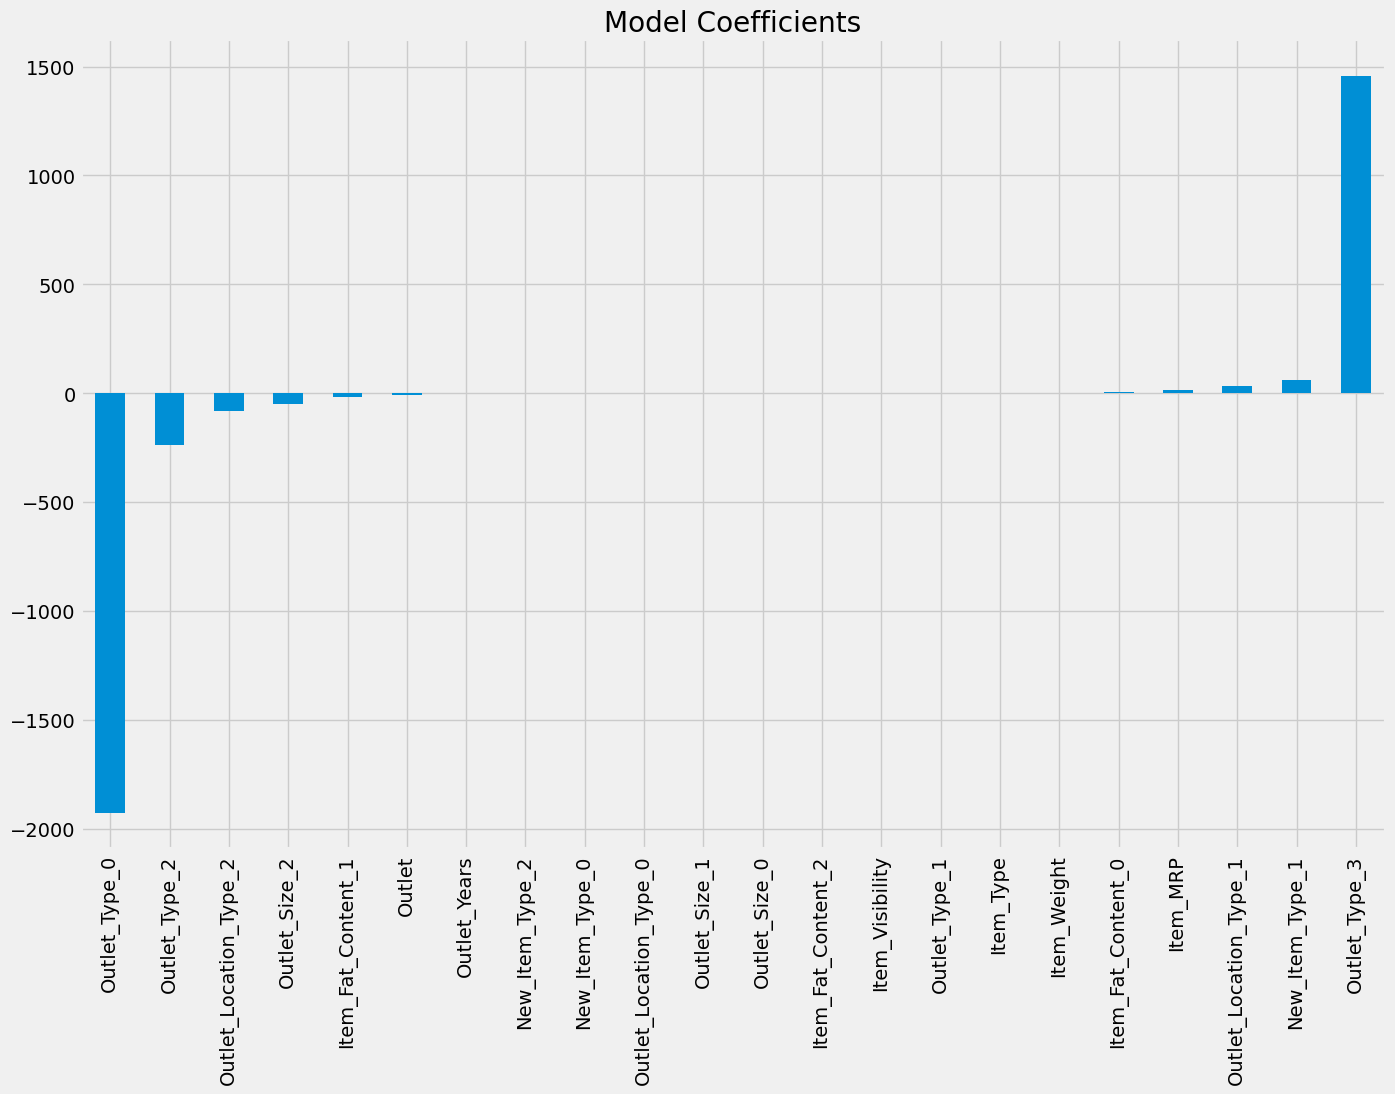

In [67]:
model = Lasso()
train(model, x_train, y_train)

### **Display of Feature Importance**

In [68]:
def train(model, x, y):
    model.fit(x, y)
    pred = model.predict(x)
    cv_score = cross_val_score(model,x,y,scoring = 'neg_mean_squared_error', cv = 10)
    print('Model Report : \n')
    print('Scoring - neg_mean_squared_error')
    print(cv_score,'\n')
    cv_score = np.abs(np.mean(cv_score))
    print('Absolute Average of neg_mean_squared_error : ',cv_score)
    cv_score = cross_val_score(model, x, y, cv = 10)
    print()
    print('R2 Score')
    print(cv_score,'\n')
    cv_score = np.mean(cv_score)
    print('Average R2 Score : ',cv_score,'\n')
    print('Accuracy for Full Data :')
    print('R2 Score : ',r2_score(y,pred),'\n')
    coef = pd.Series(model.feature_importances_, x.columns).sort_values(ascending=False)
    coef.plot(kind='bar', title="Feature Importance")
    plt.show()



### **Fitting the Decision Tree Regressor model**

Model Report : 

Scoring - neg_mean_squared_error
[-2659566.3923484  -2382598.75054077 -2382916.1481506  -2355295.61345229
 -2404527.19677184 -2654680.35889264 -2543060.36002531 -2347417.27549122
 -1986506.0622806  -2302670.79140853] 

Absolute Average of neg_mean_squared_error :  2401923.894936221

R2 Score
[0.06706364 0.19004806 0.21315695 0.26563084 0.27896226 0.01685838
 0.17636946 0.14924878 0.20845958 0.15277174] 

Average R2 Score :  0.17185696862211838 

Accuracy for Full Data :
R2 Score :  1.0 



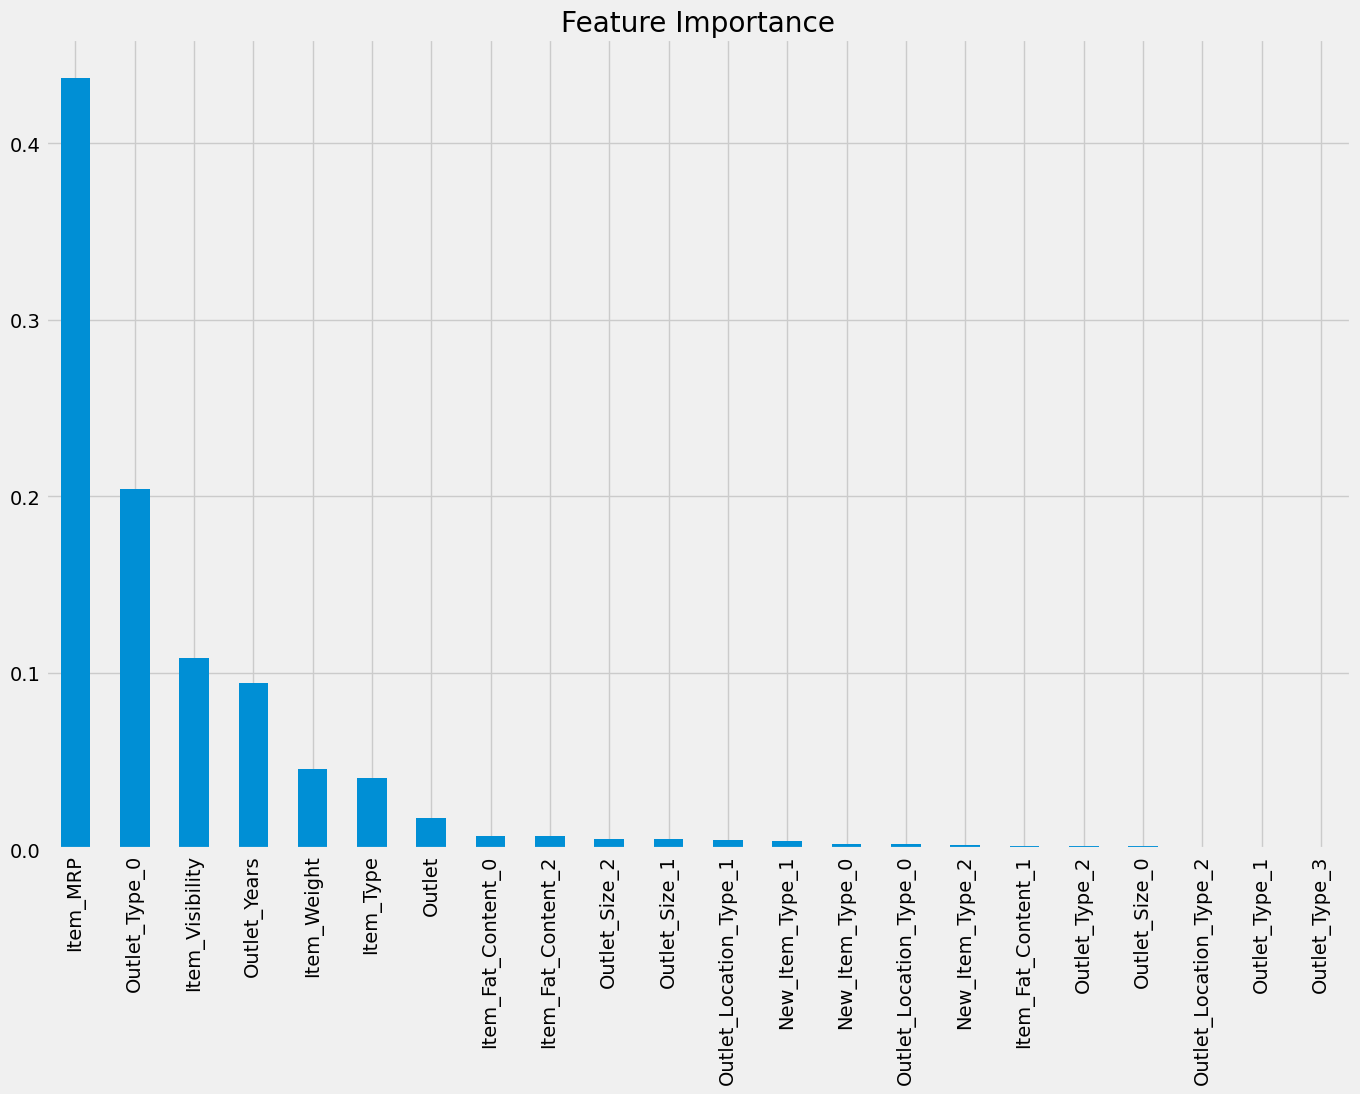

In [69]:
model = DecisionTreeRegressor()
train(model, x_train, y_train)



### **Fitting the Random Forest Regressor model**

Model Report : 

Scoring - neg_mean_squared_error
[-1255108.27285355 -1343588.77428503 -1270306.38588639 -1346978.00651946
 -1250322.63807266 -1446727.8068555  -1174943.26266614 -1408185.68809842
 -1113528.2147319  -1385084.55486004] 

Absolute Average of neg_mean_squared_error :  1299477.3604829093

R2 Score
[0.55986182 0.54693135 0.59033137 0.57755361 0.61758571 0.46420518
 0.58378033 0.48427663 0.58731838 0.49940869] 

Average R2 Score :  0.5511253065375478 

Accuracy for Full Data :
R2 Score :  0.9374865792755926 



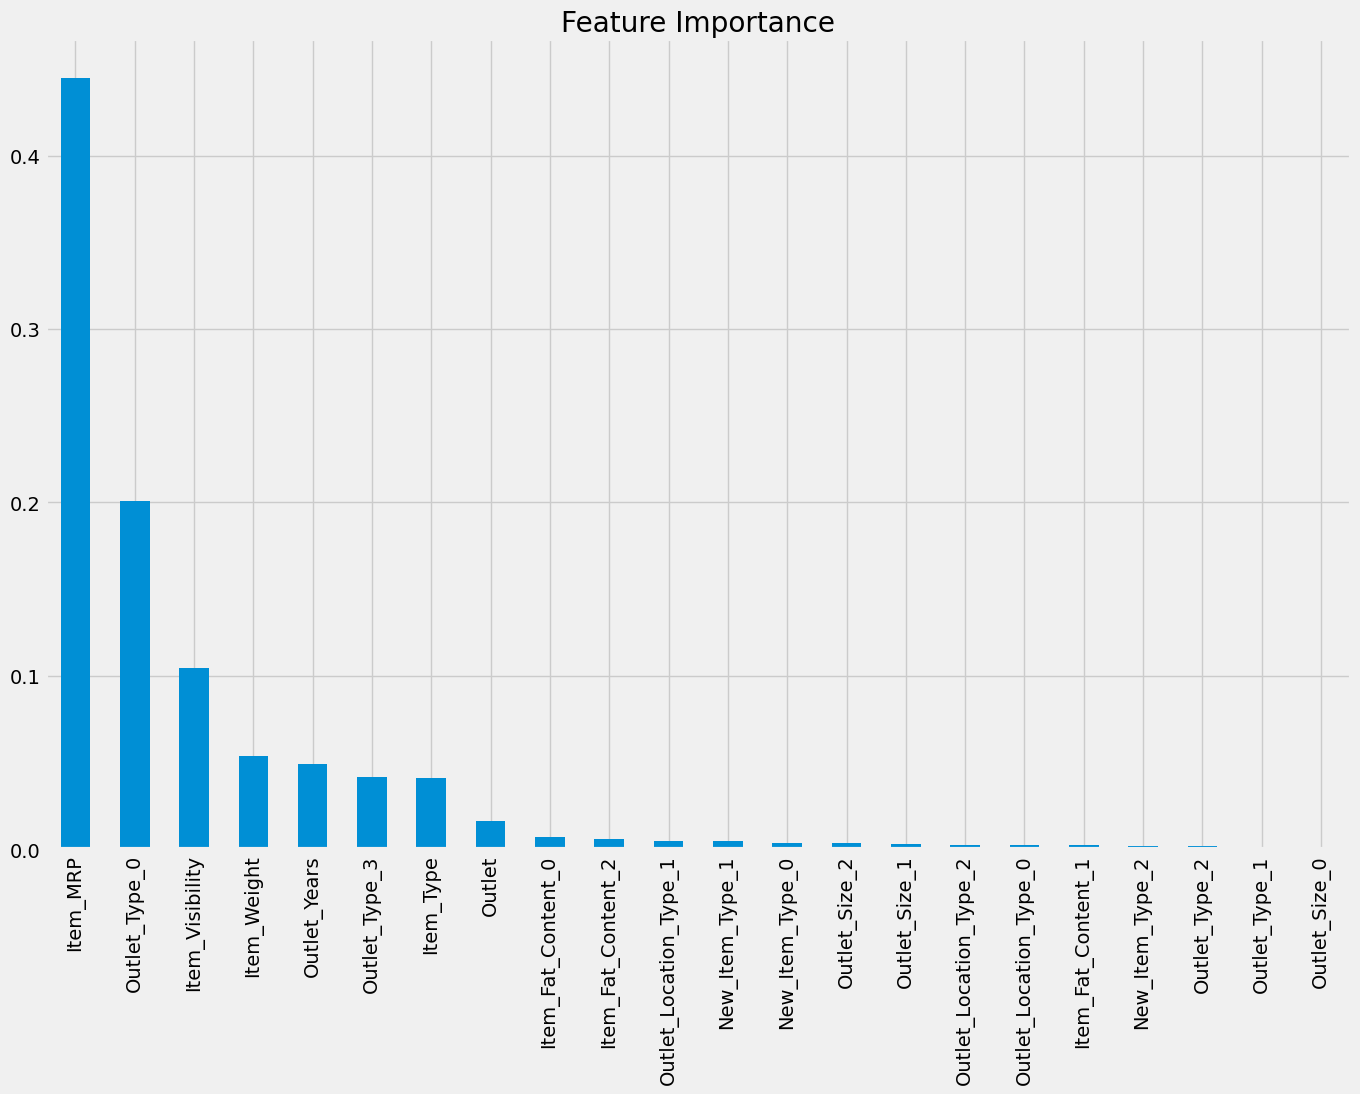

In [70]:
model = RandomForestRegressor()
train(model, x_train, y_train)


### **Fitting the Extra Trees Regressor Model**

Model Report : 

Scoring - neg_mean_squared_error
[-1438941.54945019 -1412653.40082118 -1418307.13654663 -1427856.43348015
 -1334409.84369225 -1535601.50331717 -1244981.08920305 -1519594.43648895
 -1176402.07343868 -1414858.3115237 ] 

Absolute Average of neg_mean_squared_error :  1392360.5777961947

R2 Score
[0.50850672 0.51906927 0.53401427 0.56403991 0.58352512 0.43935325
 0.5665498  0.44943912 0.56108752 0.49465524] 

Average R2 Score :  0.5220240232494615 

Accuracy for Full Data :
R2 Score :  0.9999997388754681 



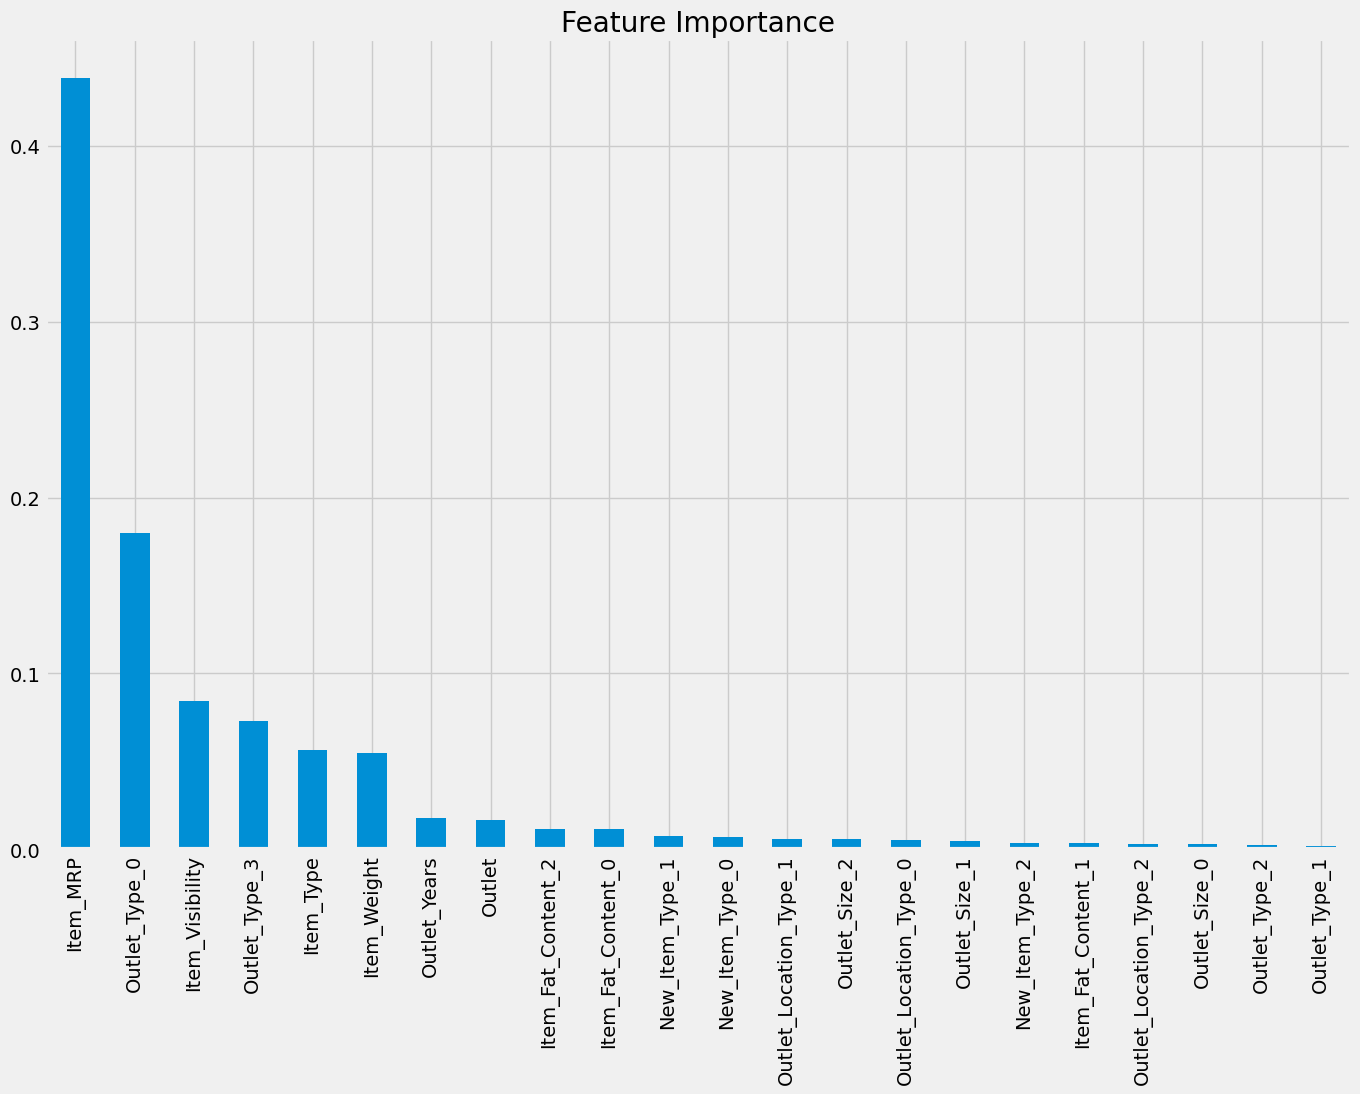

In [71]:
model = ExtraTreesRegressor()
train(model, x_train, y_train)


### **Fitting the LGBM Regressor Model**

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 5966, number of used features: 22
[LightGBM] [Info] Start training from score 2177.083082
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 5369, number of used features: 22
[LightGBM] [Info] Start training from score 2176.346306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

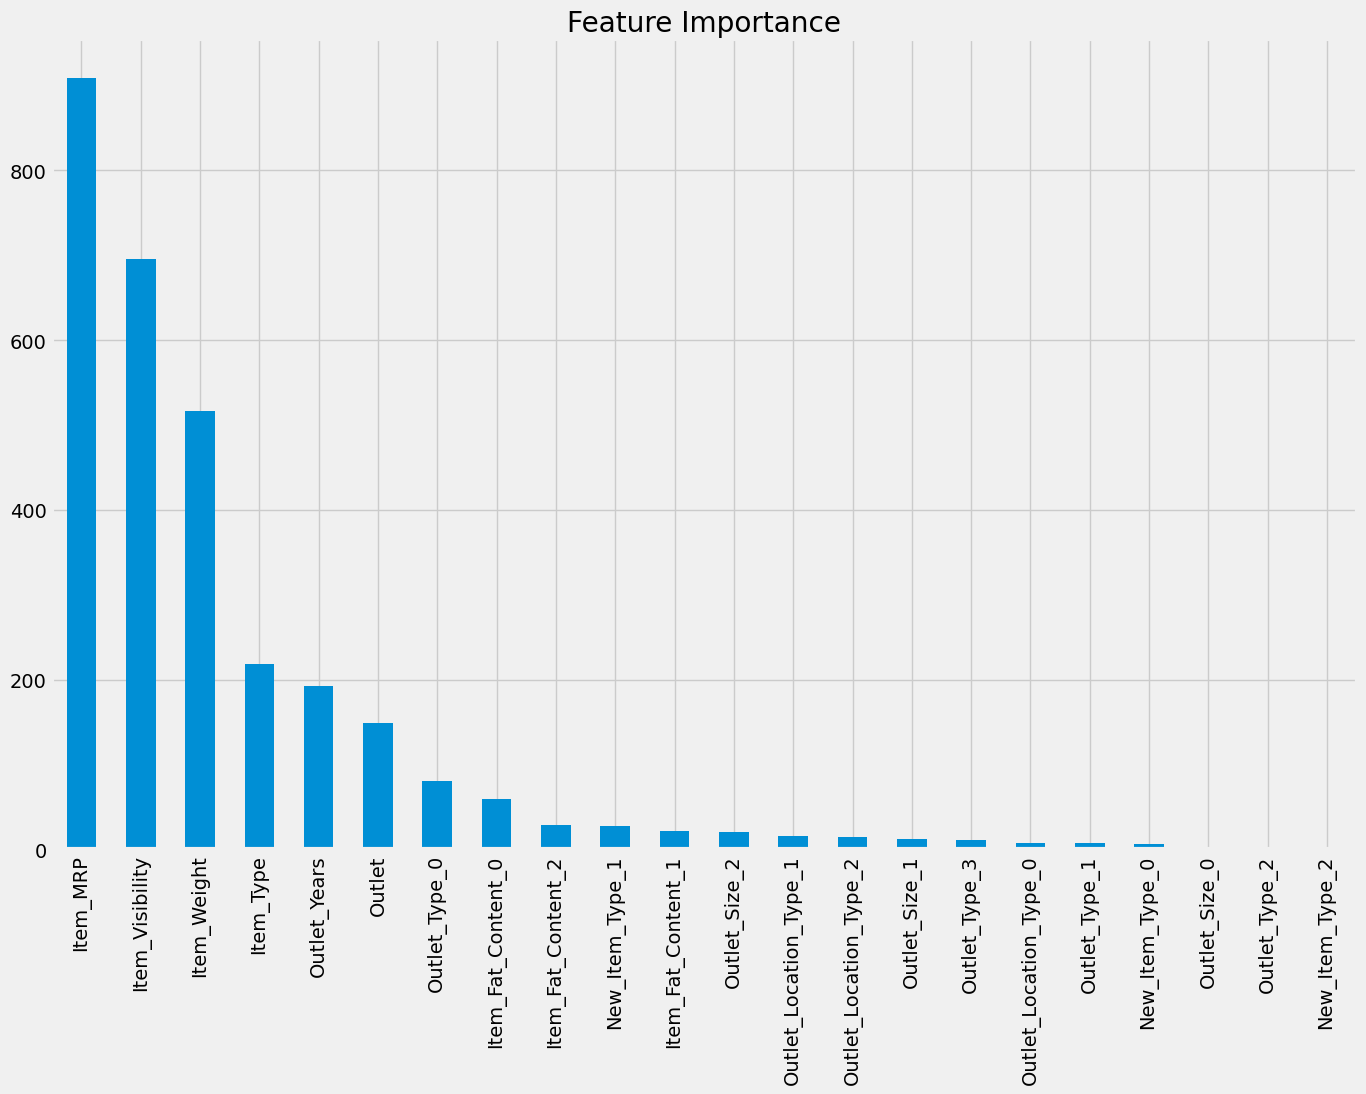

In [72]:
model = LGBMRegressor()
train(model, x_train, y_train)



### **Fitting the XGB Regressor Model**

Model Report : 

Scoring - neg_mean_squared_error
[-1392715.32380723 -1424357.19566994 -1399930.63393958 -1474098.57736987
 -1272857.00693838 -1535221.60193307 -1248727.98807695 -1568092.2770916
 -1257647.67239362 -1538944.46818014] 

Absolute Average of neg_mean_squared_error :  1411259.274540039

R2 Score
[0.51344694 0.5093663  0.53895295 0.54384627 0.60228115 0.43566206
 0.56530552 0.43519923 0.53514158 0.44674388] 

Average R2 Score :  0.5125945875160611 

Accuracy for Full Data :
R2 Score :  0.8819933050973913 



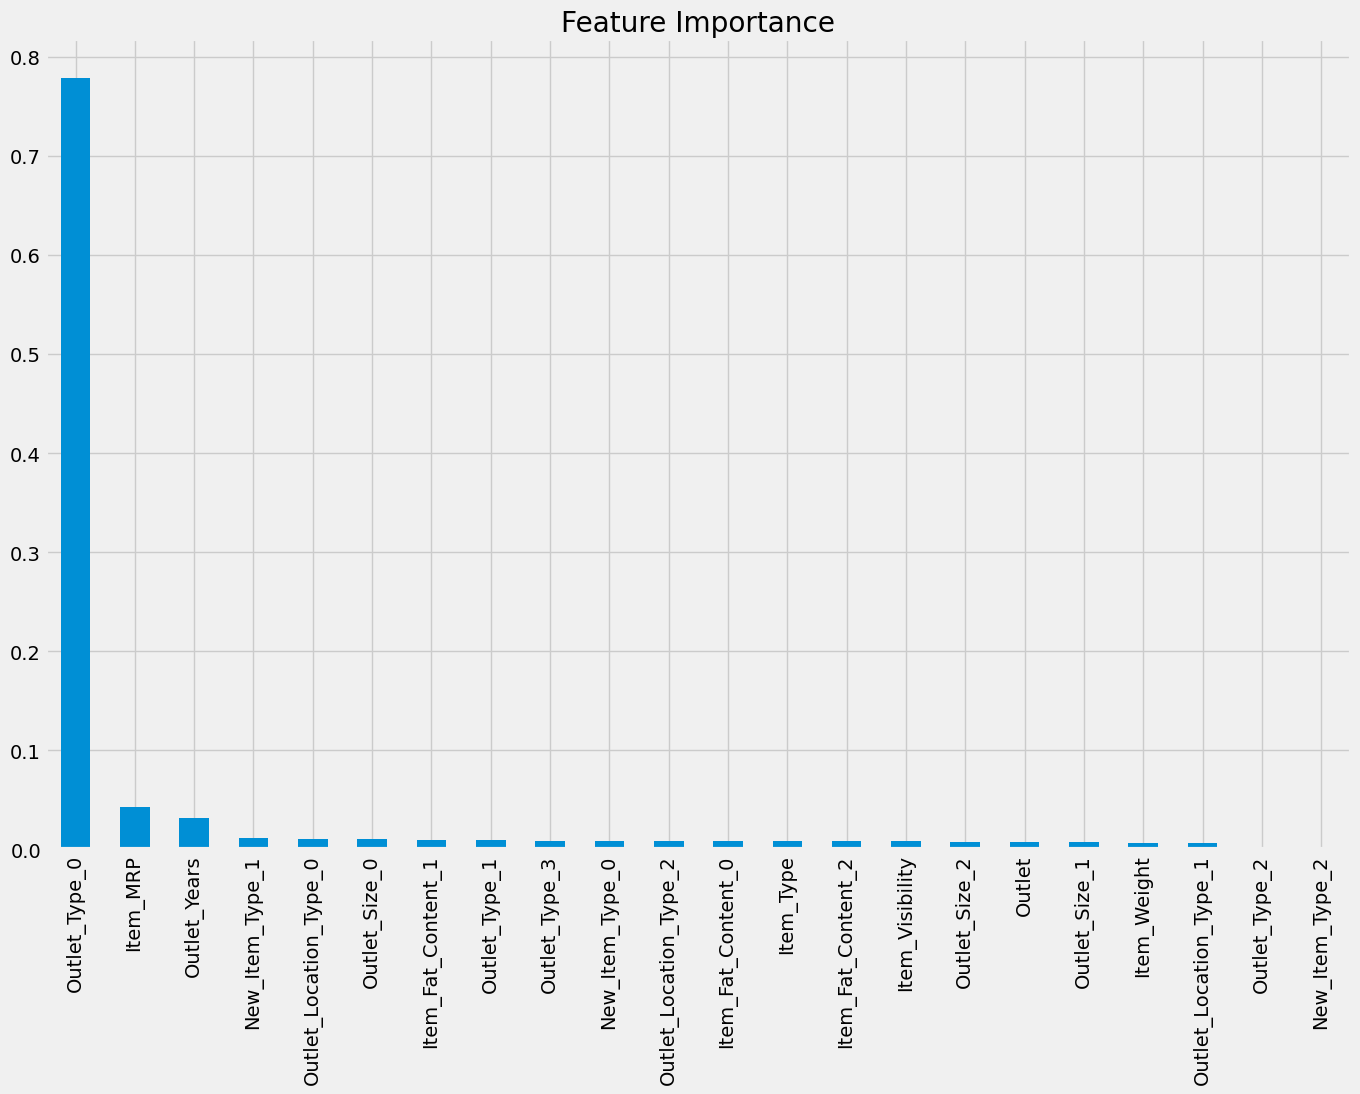

In [73]:
model = XGBRegressor()
train(model, x_train, y_train)



### **Fitting the Cat Boost Regressor Model**

Model Report : 

Scoring - neg_mean_squared_error
[-1204342.95001023 -1258326.80109096 -1236189.83533822 -1305120.10336832
 -1133897.68095895 -1358844.46809349 -1125484.0315177  -1338789.18295122
 -1056983.85106778 -1321537.20330976] 

Absolute Average of neg_mean_squared_error :  1233951.6107706637

R2 Score
[0.57925591 0.56655709 0.59287863 0.59613596 0.64570059 0.5004972
 0.60820795 0.51779039 0.60931201 0.52490258] 

Average R2 Score :  0.5741238307892427 

Accuracy for Full Data :
R2 Score :  0.7748063677888094 



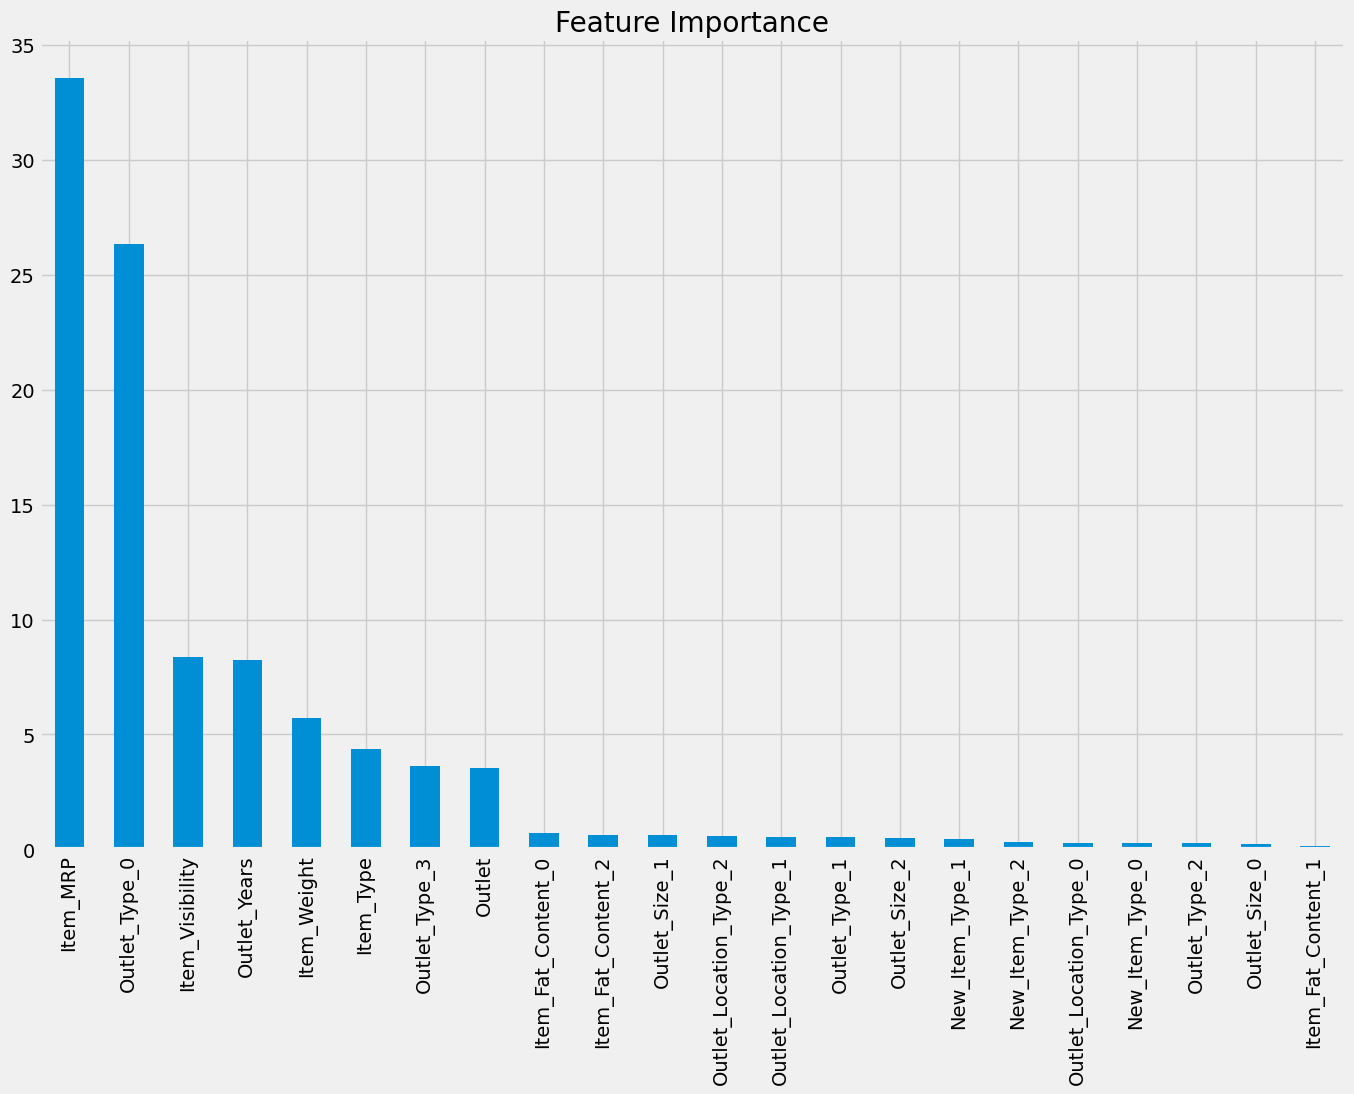

In [74]:
model = CatBoostRegressor(verbose = 0)
train(model, x_train, y_train)

## **Randomized Search CV Algorithm for Random Forest Regressor**

In [76]:
random_grid = {
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 30, num = 6)],
               'min_samples_split':[2, 5, 10, 15, 100],
               'min_samples_leaf': [1, 2, 5, 10]
}

### **Display the Best Parameters, Best Score and R2 Score**

In [77]:
RF = RandomForestRegressor()
RF = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, scoring = 'neg_mean_squared_error', n_iter =10,
                       verbose = 0, cv =10, random_state = 10, n_jobs = 1)
RF.fit(x_train, y_train)
print('Best Params : ',RF.best_params_,'\n')
print('Best Score : ',RF.best_score_,'\n')
prediction = RF.predict(x_test)
print('R2 Score : ',r2_score(y_test,prediction))

Best Params :  {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 15} 

Best Score :  -1219037.1264928072 

R2 Score :  0.574274055415868


### **Visualizing the data distribution of the dependent test variable , predicted dependent variable of the Random Forest Regressor Model against the density distribution using Seaborn Distplot**

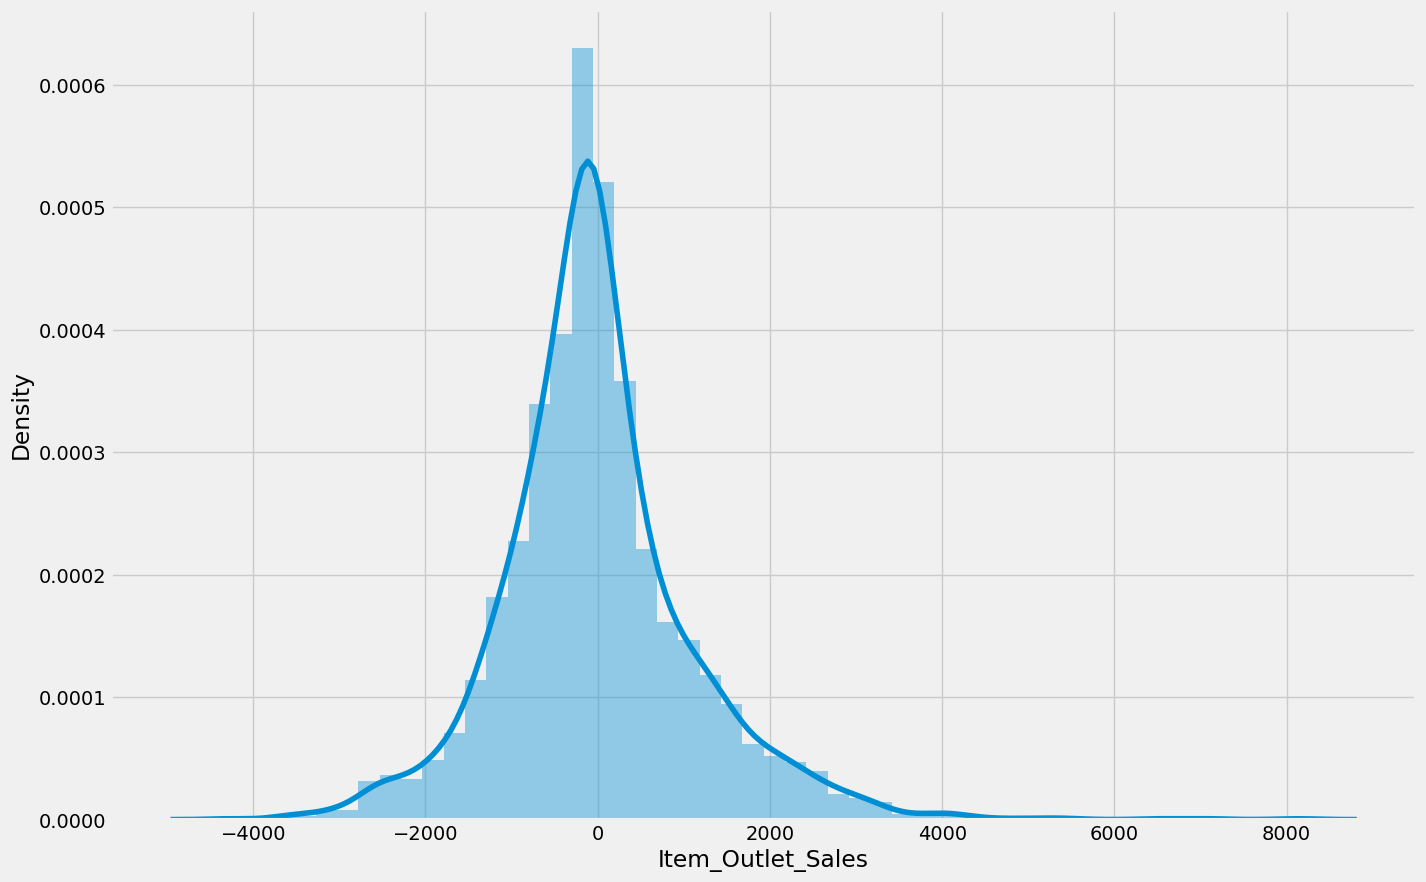

In [78]:
sns.distplot(y_test-prediction)
plt.show()

## **LGBM Regressor Model to run with Randomized Search CV Algorithm**

In [79]:
params = {
    "learning_rate": uniform(0.03, 0.3),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

### **Display the Best Parameters, Best Score and R2 Score**

In [80]:
lgb = LGBMRegressor()
lgb = RandomizedSearchCV(estimator = lgb, param_distributions = params, cv = 10, n_iter = 10, verbose = 0,
                        scoring = 'neg_mean_squared_error', n_jobs = 1, random_state = 10)
lgb.fit(x_train,y_train)
print('Best Params : ',lgb.best_params_,'\n')
print('Best Score : ',lgb.best_score_,'\n')
prediction = lgb.predict(x_test)
print('R2 Score : ',r2_score(y_test,prediction))

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

### **Visualizing the data distribution of the dependent test variable , predicted dependent variable of the LGBM Regressor Model against the density distribution using Seaborn Distplot**

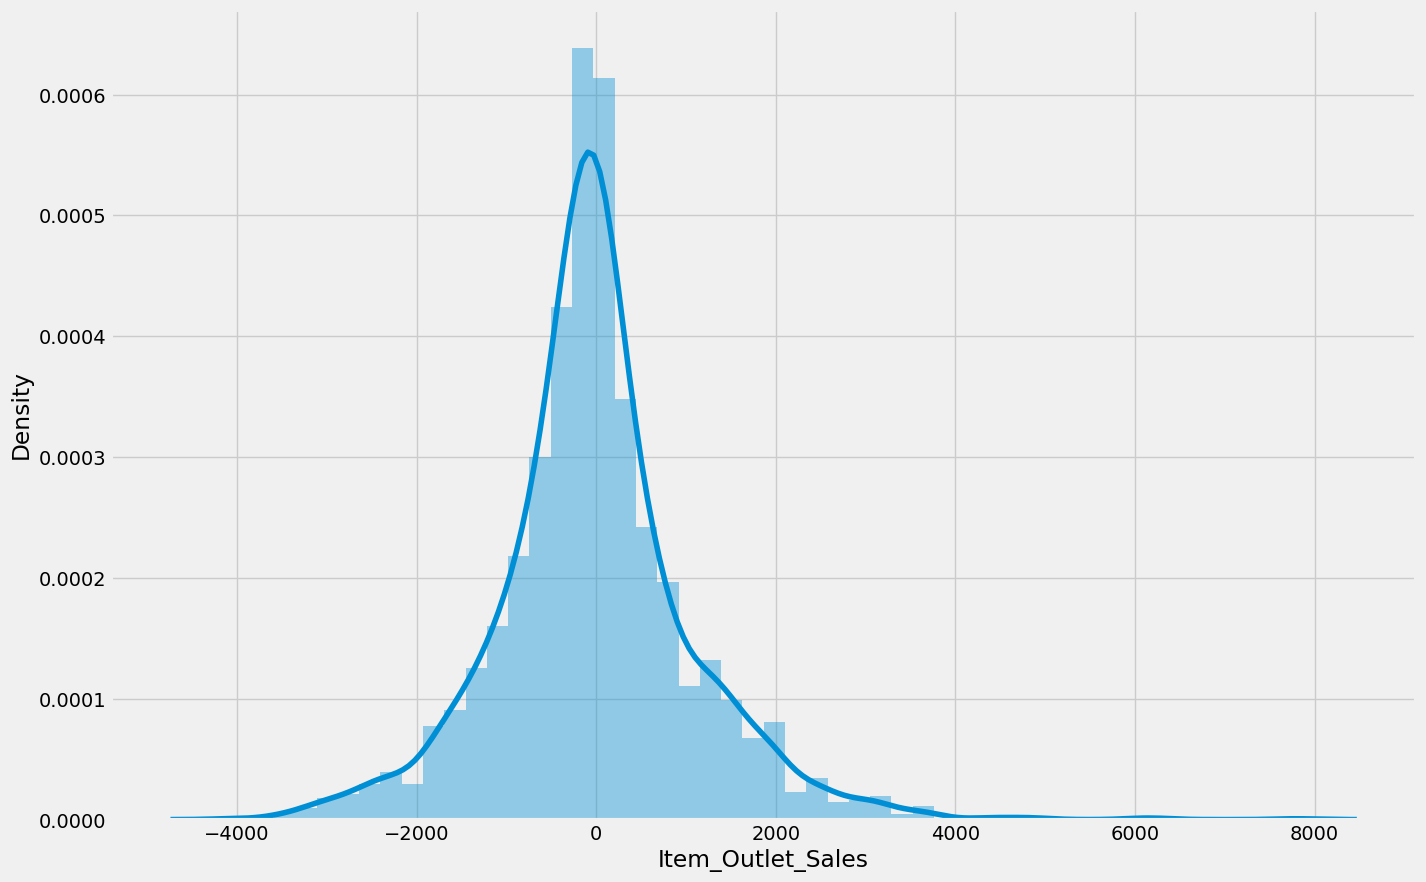

In [81]:
sns.distplot(y_test-prediction)
plt.show()

## **XGB Regressor Model to run with Randomized Search CV Algorithm**

In [82]:
params = {
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

### **Display the Best Parameters, Best Score and R2 Score**

In [83]:
xgb = XGBRegressor()
xgb = RandomizedSearchCV(estimator = xgb, param_distributions = params, cv = 10, n_iter = 10, verbose = 0,
                        scoring = 'neg_mean_squared_error', n_jobs = 1, random_state = 10)
xgb.fit(x_train, y_train)
print('Best Params : ',xgb.best_params_,'\n')
print('Best Score : ',xgb.best_score_,'\n')
prediction = xgb.predict(x_test)
print('R2 Score : ',r2_score(y_test,prediction))

Best Params :  {'gamma': 0.15961804449427264, 'learning_rate': 0.057137804781272214, 'max_depth': 2, 'n_estimators': 107, 'subsample': 0.6307422006984988} 

Best Score :  -1167016.8580361078 

R2 Score :  0.5959187228573255


### **Visualizing the data distribution of the dependent test variable , predicted dependent variable of the XGB Regressor Model against the density distribution using Seaborn Distplot**

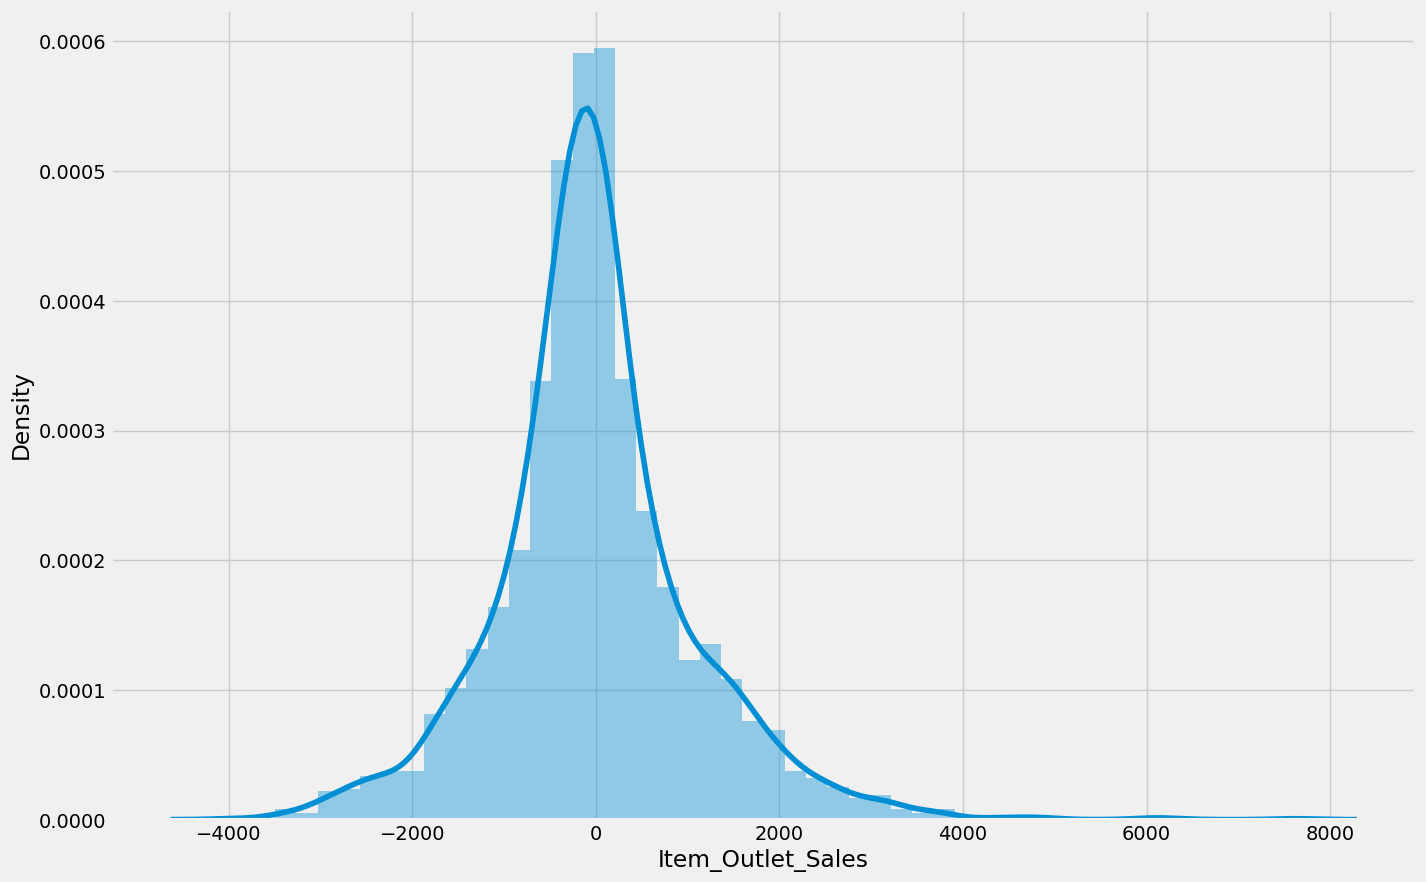

In [84]:
sns.distplot(y_test-prediction)
plt.show()

## **CatBoost Regressor Model to run with Randomized Search CV Algorithm**

In [85]:
params = {
    "learning_rate": uniform(0.03, 0.3),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

### **Display the Best Parameters, Best Score and R2 Score**

In [86]:
cat = CatBoostRegressor(verbose = 0)
cat = RandomizedSearchCV(estimator = cat, param_distributions = params, cv = 10, n_iter = 10, verbose = 0,
                        scoring = 'neg_mean_squared_error', n_jobs = 1, random_state = 10)
cat.fit(x_train,y_train)
print('Best Params : ',cat.best_params_,'\n')
print('Best Score : ',cat.best_score_,'\n')
prediction = cat.predict(x_test)
print('R2 Score : ',r2_score(y_test,prediction))

Best Params :  {'learning_rate': 0.08941885942788719, 'max_depth': 2, 'n_estimators': 109, 'subsample': 0.6676443346250142} 

Best Score :  -1162841.1046650507 

R2 Score :  0.5976757966600554


### **Visualizing the data distribution of the dependent test variable , predicted dependent variable of the CatBoost Regressor Model against the density distribution using Seaborn Distplot**

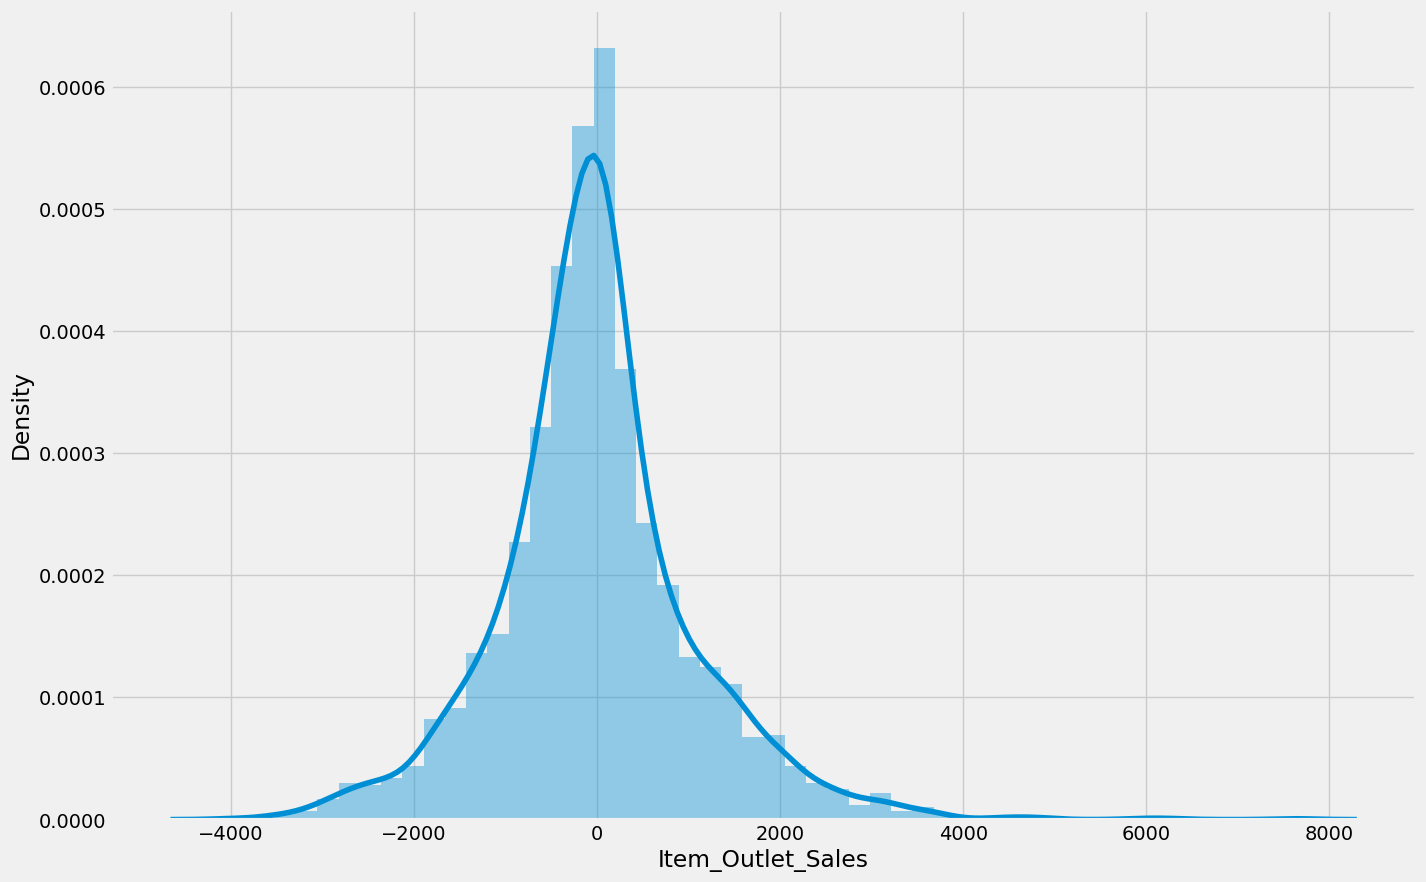

In [87]:
sns.distplot(y_test-prediction)
plt.show()

## **Fitting the CatBoost Regressor Model**

In [88]:
cat = CatBoostRegressor(learning_rate = 0.08941885942788719, max_depth = 2, n_estimators = 109,
                        subsample = 0.6676443346250142, verbose = 0)
cat.fit(x_train,y_train)
predictions = cat.predict(x_test)
print('R2 score : ',r2_score(y_test,predictions))

R2 score :  0.5976757966600554


# **6. Model Testing**

In [89]:
pickle.dump(cat,open('Model.pkl','wb'))

In [90]:
model = pickle.load(open('Model.pkl','rb'))
fpred = model.predict(x)
print('R2 Score of Full Data : ',r2_score(y,fpred))

R2 Score of Full Data :  0.6053656226149531


# **Conclusion**

1. The code performs a comprehensive analysis of sales data, encompassing exploratory data analysis, data cleaning, visualization, and model training.

2.  Multiple regression models (Linear Regression, Ridge, Lasso, Decision Tree, Random Forest, Extra Trees, LGBM, XGBoost, and CatBoost) are trained and evaluated using metrics like R2 score and negative mean squared error.

3. Hyperparameter tuning is performed using RandomizedSearchCV for Random Forest, LGBM, XGBoost, and CatBoost regressors to optimize model performance.

4. Feature importance is visualized for tree-based models, providing insights into the most influential factors driving sales.

5. The best-performing model (CatBoost Regressor) is saved using pickle for future deployment and prediction on new data, demonstrating a complete machine learning workflow.
